# Предсказание цены компьютера

## Содержание
1. [Загрузка данных и библиотек](#1)
2. [Первичный осмотр данных](#2)
3. [Обработка пропусков и типов данных](#3)
4. [Анализ целевой переменной (price)](#4)
5. [Анализ числовых признаков](#5)
6. [Анализ категориальных признаков](#6)
7. [Корреляционный анализ](#7)
8. [Выбросы](#8)
9. [Feature Engineering](#9)
10. [Подготовка данных для моделирования](#10)
11. [Модели: LinearRegression, Lasso, Ridge, DecisionTreeRegressor](#11)
12. [Кросс-валидация для оценки качества](#12)
13. [Подбор гиперпараметров (GridSearchCV / cross_val_score)](#13)
14. [Сравнение моделей](#14)
15. [Выводы](#15)

<a id='1'></a>
## 1. Загрузка данных и библиотек

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, KFold
)
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, 
    mean_absolute_percentage_error
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

RANDOM_STATE = 42

In [2]:
df = pd.read_csv('computer_prices_all.csv')
print(f'Размер датасета: {df.shape}')
df.head()

Размер датасета: (100000, 33)


,device_type,brand,model,release_year,os,form_factor,cpu_brand,cpu_model,cpu_tier,cpu_cores,...,resolution,refresh_hz,battery_wh,charger_watts,psu_watts,wifi,bluetooth,weight_kg,warranty_months,price
0,Desktop,Samsung,Samsung Forge XDI,2022,Windows,ATX,Intel,Intel i5-11129,3,12,...,2560x1440,90,0,0,750,Wi-Fi 6,5.1,11.00,36,1383.99
1,Laptop,Samsung,Samsung Pro KM8,2022,Windows,Mainstream,Intel,Intel i7-11114,4,12,...,1920x1080,90,56,120,0,Wi-Fi 6,5.3,2.03,12,2274.99
2,Desktop,Lenovo,Lenovo Strix BIE,2024,macOS,SFF,AMD,AMD Ryzen 5 5168,2,8,...,3440x1440,120,0,0,850,Wi-Fi 6,5.0,7.00,24,1879.99
3,Desktop,Dell,Dell Cube AXR,2024,Windows,ATX,AMD,AMD Ryzen 5 7550,2,6,...,3440x1440,120,0,0,650,Wi-Fi 6,5.2,6.00,36,1331.99
4,Laptop,Gigabyte,Gigabyte Pro IX1,2024,Linux,Gaming,AMD,AMD Ryzen 7 6230,5,16,...,2560x1600,90,80,90,0,Wi-Fi 6,5.2,1.50,12,2681.99


<a id='2'></a>
## 2. Первичный осмотр данных

In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   device_type          100000 non-null  str    
 1   brand                100000 non-null  str    
 2   model                100000 non-null  str    
 3   release_year         100000 non-null  int64  
 4   os                   100000 non-null  str    
 5   form_factor          100000 non-null  str    
 6   cpu_brand            100000 non-null  str    
 7   cpu_model            100000 non-null  str    
 8   cpu_tier             100000 non-null  int64  
 9   cpu_cores            100000 non-null  int64  
 10  cpu_threads          100000 non-null  int64  
 11  cpu_base_ghz         100000 non-null  float64
 12  cpu_boost_ghz        100000 non-null  float64
 13  gpu_brand            100000 non-null  str    
 14  gpu_model            100000 non-null  str    
 15  gpu_tier             100000 n

In [4]:
df.describe()

,release_year,cpu_tier,cpu_cores,cpu_threads,cpu_base_ghz,cpu_boost_ghz,gpu_tier,vram_gb,ram_gb,storage_gb,storage_drive_count,display_size_in,refresh_hz,battery_wh,charger_watts,psu_watts,bluetooth,weight_kg,warranty_months,price
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000
mean,2022.320850,3.153490,10.515740,19.372700,2.591322,3.531310,2.991350,6.152180,39.706400,903.936000,1.524980,20.126655,98.464860,41.813470,61.383450,272.520500,5.084764,4.289699,22.20036,1928.764220
std,2.025761,1.373175,5.044092,9.718426,0.336435,0.350024,1.459643,3.964926,31.902684,774.243654,0.797284,6.709577,43.301652,35.868841,62.795034,354.686355,0.245977,3.814628,10.23190,580.492689
min,2018.000000,1.000000,4.000000,4.000000,2.000000,2.800000,1.000000,0.000000,8.000000,256.000000,1.000000,13.300000,60.000000,0.000000,0.000000,0.000000,4.200000,0.920000,12.00000,372.990000
25%,2021.000000,2.000000,6.000000,12.000000,2.400000,3.300000,2.000000,4.000000,16.000000,512.000000,1.000000,14.000000,60.000000,0.000000,0.000000,0.000000,5.000000,1.500000,12.00000,1503.990000
50%,2023.000000,3.000000,8.000000,16.000000,2.600000,3.500000,3.000000,6.000000,32.000000,512.000000,1.000000,16.000000,90.000000,56.000000,65.000000,0.000000,5.100000,2.000000,24.00000,1863.990000
75%,2024.000000,4.000000,14.000000,24.000000,2.800000,3.800000,4.000000,8.000000,64.000000,1024.000000,2.000000,27.000000,120.000000,70.000000,90.000000,650.000000,5.200000,7.000000,24.00000,2287.990000
max,2025.000000,6.000000,28.000000,56.000000,3.400000,4.500000,6.000000,16.000000,144.000000,4096.000000,4.000000,34.000000,240.000000,99.000000,240.000000,1200.000000,5.300000,16.000000,48.00000,10984.990000


In [5]:
df.describe(include='object')

,device_type,brand,model,os,form_factor,cpu_brand,cpu_model,gpu_brand,gpu_model,storage_type,display_type,resolution,wifi
count,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
unique,2,10,99036,4,10,3,26971,4,49,4,6,6,4
top,Laptop,Lenovo,ASUS Slim R6S,Windows,Mainstream,Intel,Apple M2 Pro,NVIDIA,Apple Integrated,NVMe,LED,1920x1080,Wi-Fi 6
freq,59844,15992,3,71817,17819,52774,1389,54712,18922,45059,32000,47993,46149


In [6]:
print('Дубликаты:', df.duplicated().sum())
print()
print('Уникальные значения по столбцам:')
for col in df.columns:
    print(f'{col}: {df[col].nunique()}')

Дубликаты: 0

Уникальные значения по столбцам:
device_type: 2
brand: 10
model: 99036
release_year: 8
os: 4
form_factor: 10
cpu_brand: 3
cpu_model: 26971
cpu_tier: 6
cpu_cores: 12
cpu_threads: 25
cpu_base_ghz: 8
cpu_boost_ghz: 18
gpu_brand: 4
gpu_model: 49
gpu_tier: 6
vram_gb: 8
ram_gb: 15
storage_type: 4
storage_gb: 5
storage_drive_count: 4
display_type: 6
display_size_in: 9
resolution: 6
refresh_hz: 6
battery_wh: 8
charger_watts: 7
psu_watts: 9
wifi: 4
bluetooth: 5
weight_kg: 47
warranty_months: 4
price: 3366


# Наблюдение
Есть признаки, где достаточно большое количество уникальных значений. Посмотрим на эти значения относительно размера датасета, чтобы оценить кардинальность признаков.

In [7]:
card_features = {}
for col in df.columns.drop('price'):
    card_features[col] = df[col].nunique()*100 / len(df)

sorted_card_features = dict(sorted(card_features.items(), key=lambda item: item[1], reverse=True))
for key, item in sorted_card_features.items():
    print(f'{key}: {item} %')

model: 99.036 %
cpu_model: 26.971 %
gpu_model: 0.049 %
weight_kg: 0.047 %
cpu_threads: 0.025 %
cpu_boost_ghz: 0.018 %
ram_gb: 0.015 %
cpu_cores: 0.012 %
brand: 0.01 %
form_factor: 0.01 %
display_size_in: 0.009 %
psu_watts: 0.009 %
release_year: 0.008 %
cpu_base_ghz: 0.008 %
vram_gb: 0.008 %
battery_wh: 0.008 %
charger_watts: 0.007 %
cpu_tier: 0.006 %
gpu_tier: 0.006 %
display_type: 0.006 %
resolution: 0.006 %
refresh_hz: 0.006 %
storage_gb: 0.005 %
bluetooth: 0.005 %
os: 0.004 %
gpu_brand: 0.004 %
storage_type: 0.004 %
storage_drive_count: 0.004 %
wifi: 0.004 %
warranty_months: 0.004 %
cpu_brand: 0.003 %
device_type: 0.002 %


# НАБЛЮДЕНИЕ
Имеются признаки с высокой кардинальностью: "**model**" и "**cpu_model**". В рамках *feature engineering* это столбцы будут удалены

In [8]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()

print(f'Числовые признаки ({len(num_cols)}): {num_cols}')
print()
print(f'Категориальные признаки ({len(cat_cols)}): {cat_cols}')

Числовые признаки (20): ['release_year', 'cpu_tier', 'cpu_cores', 'cpu_threads', 'cpu_base_ghz', 'cpu_boost_ghz', 'gpu_tier', 'vram_gb', 'ram_gb', 'storage_gb', 'storage_drive_count', 'display_size_in', 'refresh_hz', 'battery_wh', 'charger_watts', 'psu_watts', 'bluetooth', 'weight_kg', 'warranty_months', 'price']

Категориальные признаки (13): ['device_type', 'brand', 'model', 'os', 'form_factor', 'cpu_brand', 'cpu_model', 'gpu_brand', 'gpu_model', 'storage_type', 'display_type', 'resolution', 'wifi']


<a id='3'></a>
## 3. Обработка пропусков

In [9]:
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'count': missing, 'percent': missing_pct})
missing_df = missing_df[missing_df['count'] > 0].sort_values('percent', ascending=False)

if len(missing_df) > 0:
    print('Пропуски в данных:')
    display(missing_df)
else:
    print('Пропусков нет!')

Пропусков нет!


<a id='4'></a>
## 4. Анализ целевой переменной (price)

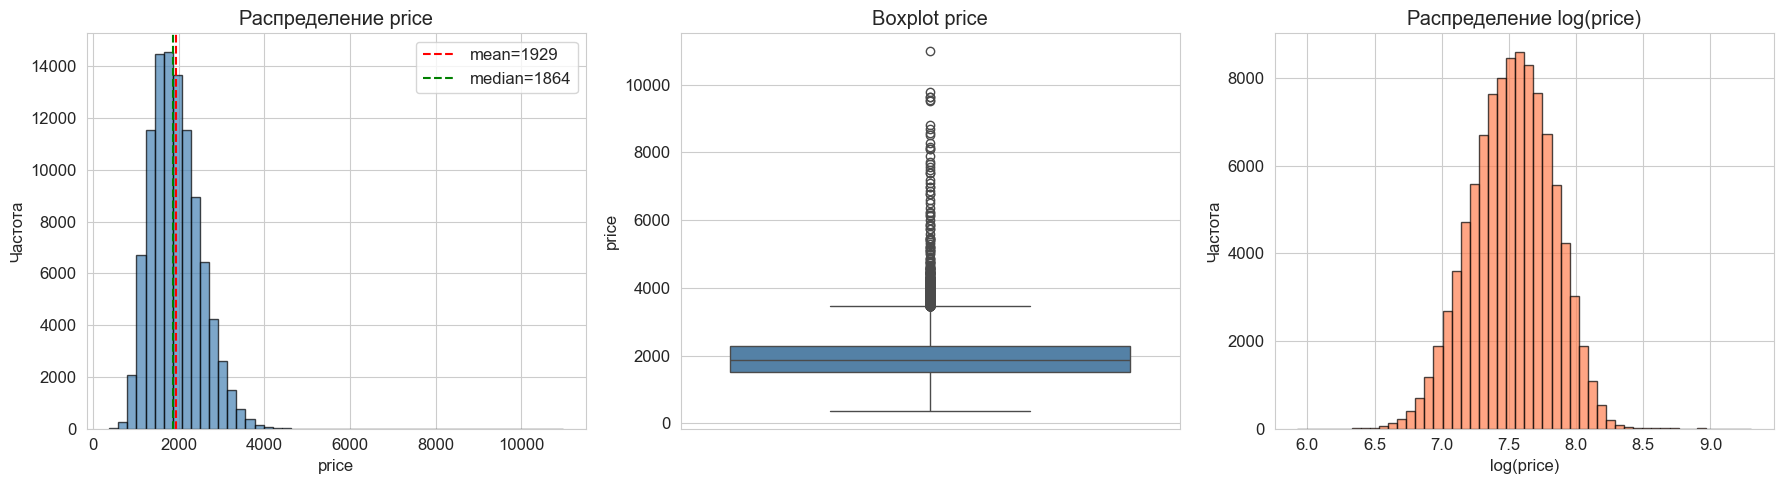

Статистика по price:
count    100000.000000
mean       1928.764220
std         580.492689
min         372.990000
25%        1503.990000
50%        1863.990000
75%        2287.990000
max       10984.990000
Name: price, dtype: float64


In [10]:
target = 'price'

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Гистограмма
axes[0].hist(df[target], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title(f'Распределение {target}')
axes[0].set_xlabel(target)
axes[0].set_ylabel('Частота')
axes[0].axvline(df[target].mean(), color='red', linestyle='--', label=f'mean={df[target].mean():.0f}')
axes[0].axvline(df[target].median(), color='green', linestyle='--', label=f'median={df[target].median():.0f}')
axes[0].legend()

# Boxplot
sns.boxplot(y=df[target], ax=axes[1], color='steelblue')
axes[1].set_title(f'Boxplot {target}')

# log-трансформация
axes[2].hist(np.log1p(df[target]), bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[2].set_title(f'Распределение log({target})')
axes[2].set_xlabel(f'log({target})')
axes[2].set_ylabel('Частота')

plt.tight_layout()
plt.show()

print(f'Статистика по {target}:')
print(df[target].describe())

# НАБЛЮДЕНИЕ
1. Природа данных: Наблюдается значительное количество выбросов в переменной price. Однако эти значения являются естественными для рынка (не технические ошибки), поэтому их удаление нецелесообразно, так как они содержат важную информацию о дорогом сегменте.
2. Выбор метрики: Из-за чувствительности MSE к выбросам, в качестве основной метрики для оценки качества модели будет выбрана MAE, как более устойчивая к аномалиям. Но в рамках данного учебного проекта мы рассмотрим и другие метрики.
3. Эксперимент с логарифмированием: Распределение log(price) визуально ближе к нормальному. Будет проведено сравнение двух подходов: обучение на исходных данных и на логарифмированных (через создание df_log перед этапом обучения). Это позволит определить, помогает ли сжатие шкалы таргета улучшить предсказательную способность модели.

<a id='5'></a>
## 5. Анализ числовых признаков

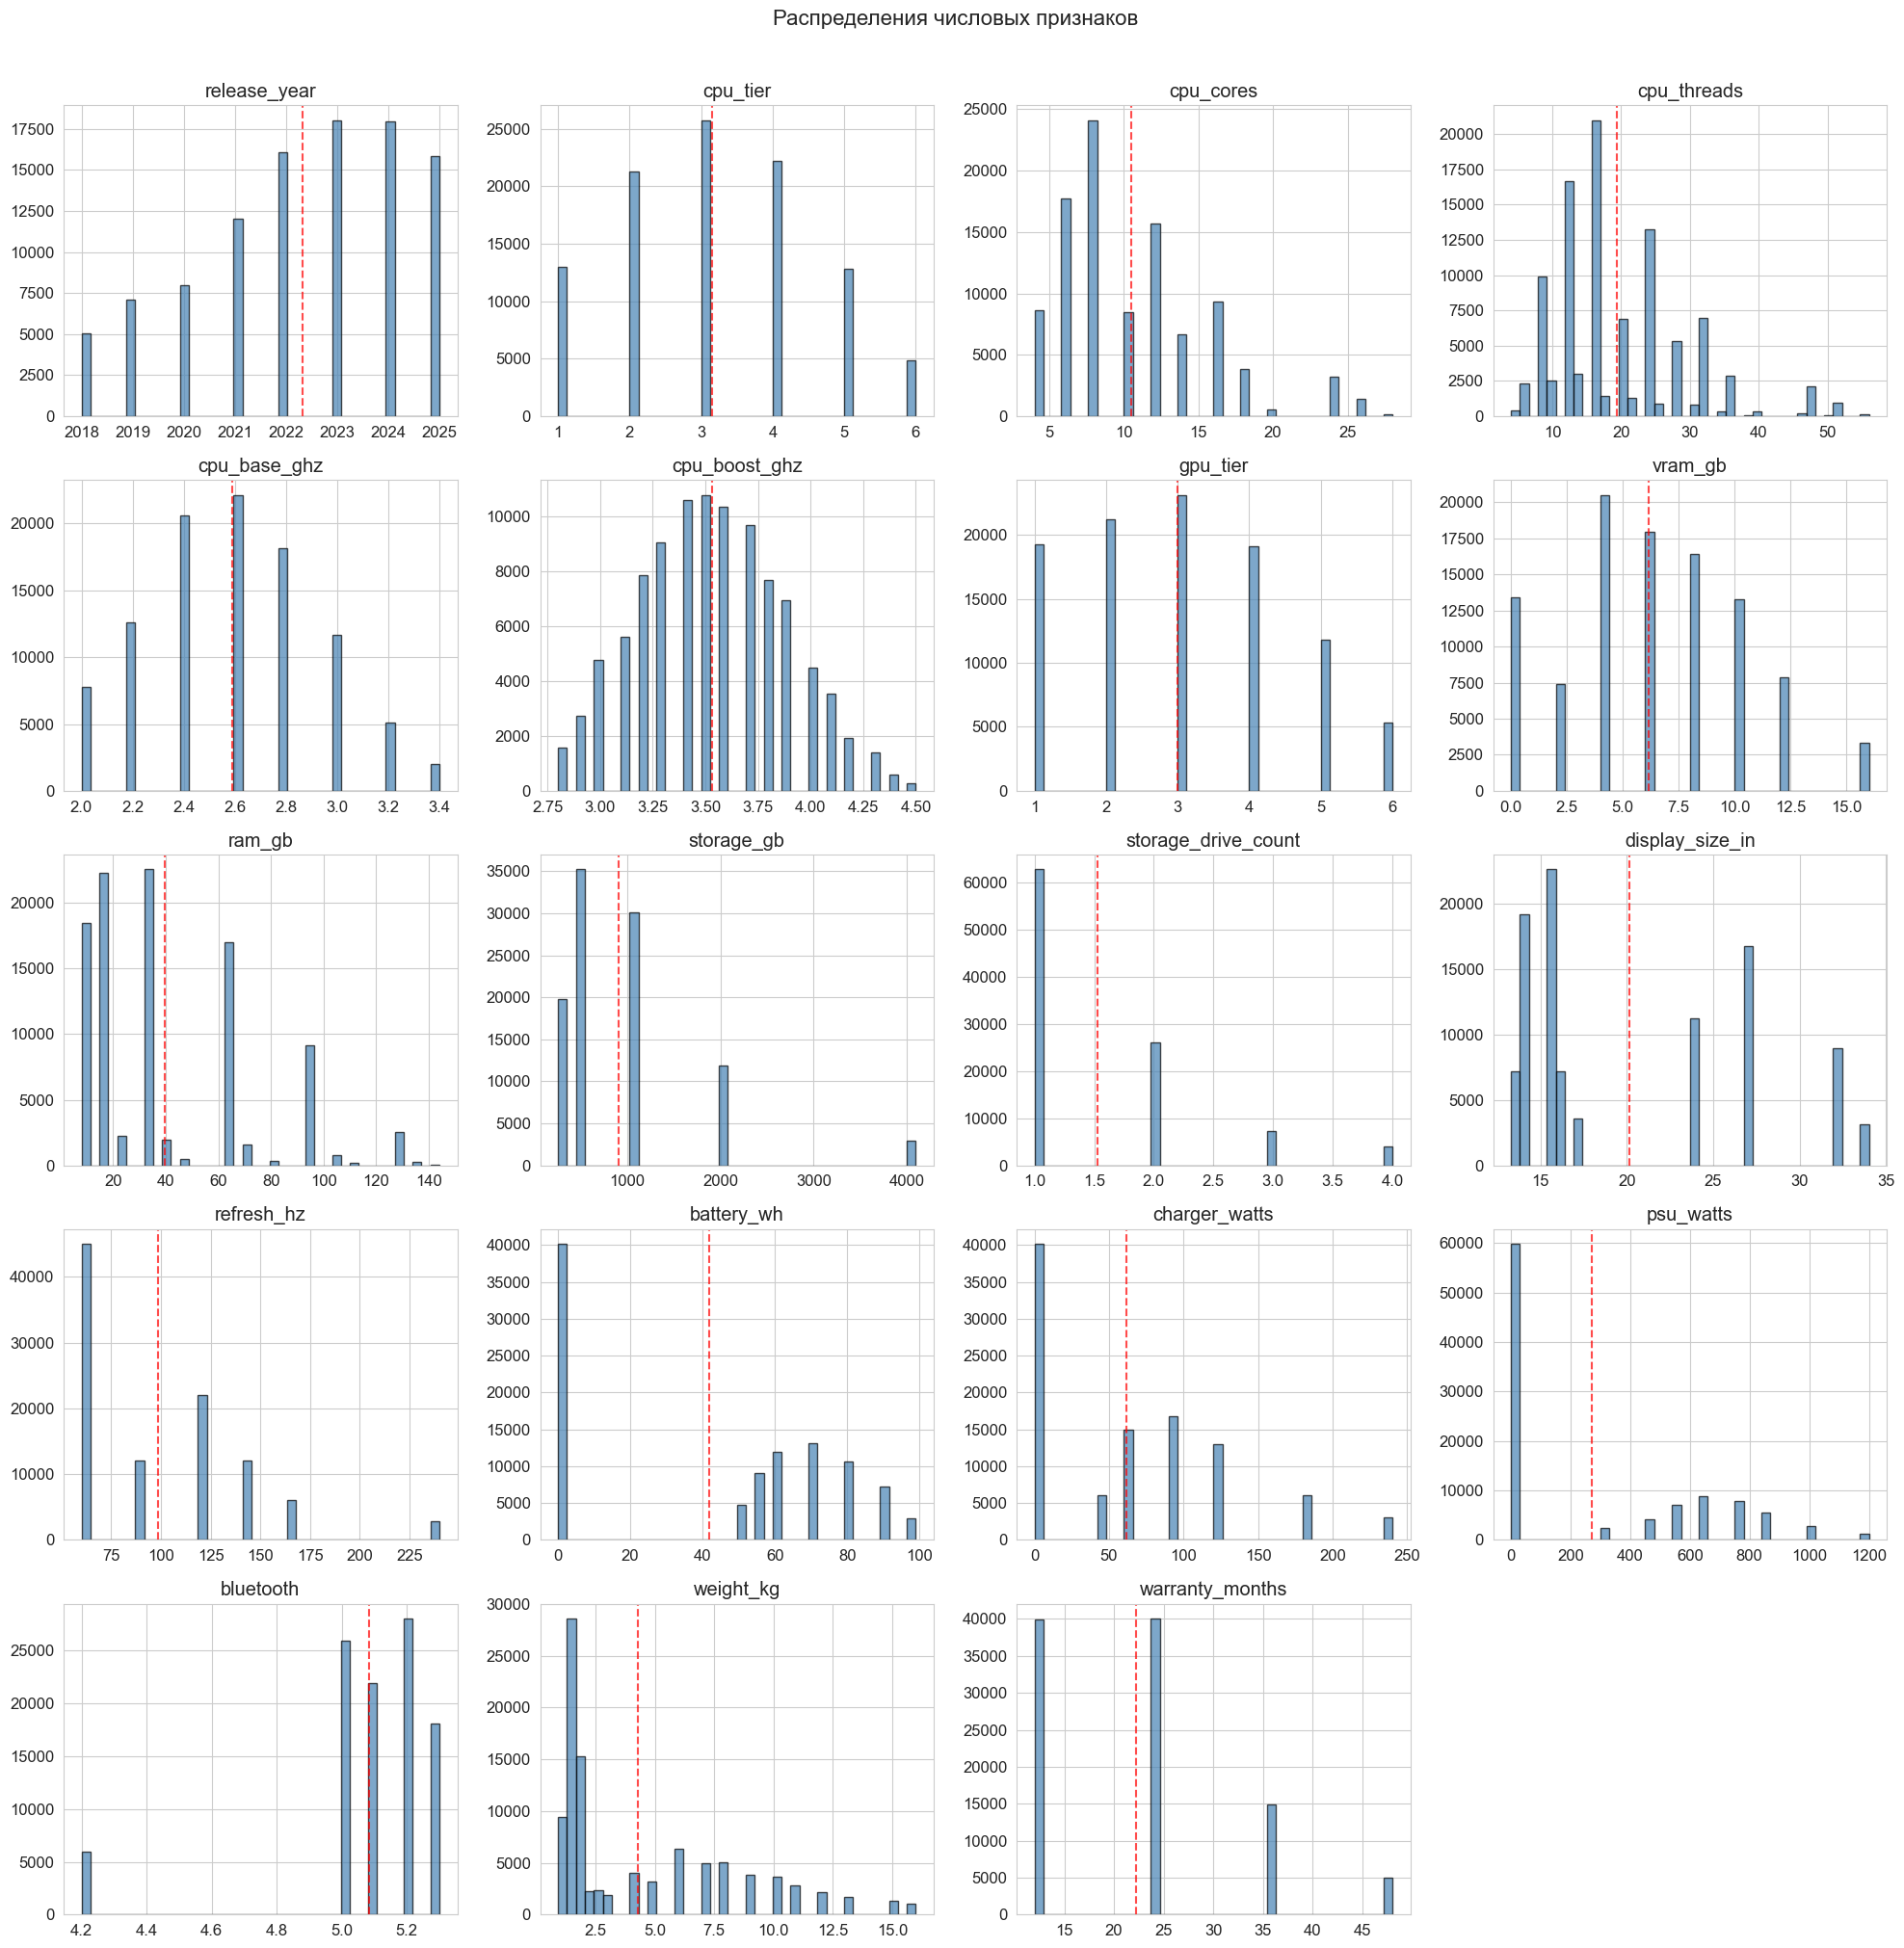

In [11]:
num_features = [c for c in num_cols if c != target]

n = len(num_features)
ncols = 4
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

for i, col in enumerate(num_features):
    axes[i].hist(df[col], bins=40, edgecolor='black', alpha=0.7, color='steelblue')
    axes[i].set_title(col)
    axes[i].axvline(df[col].mean(), color='red', linestyle='--', alpha=0.7)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Распределения числовых признаков', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()


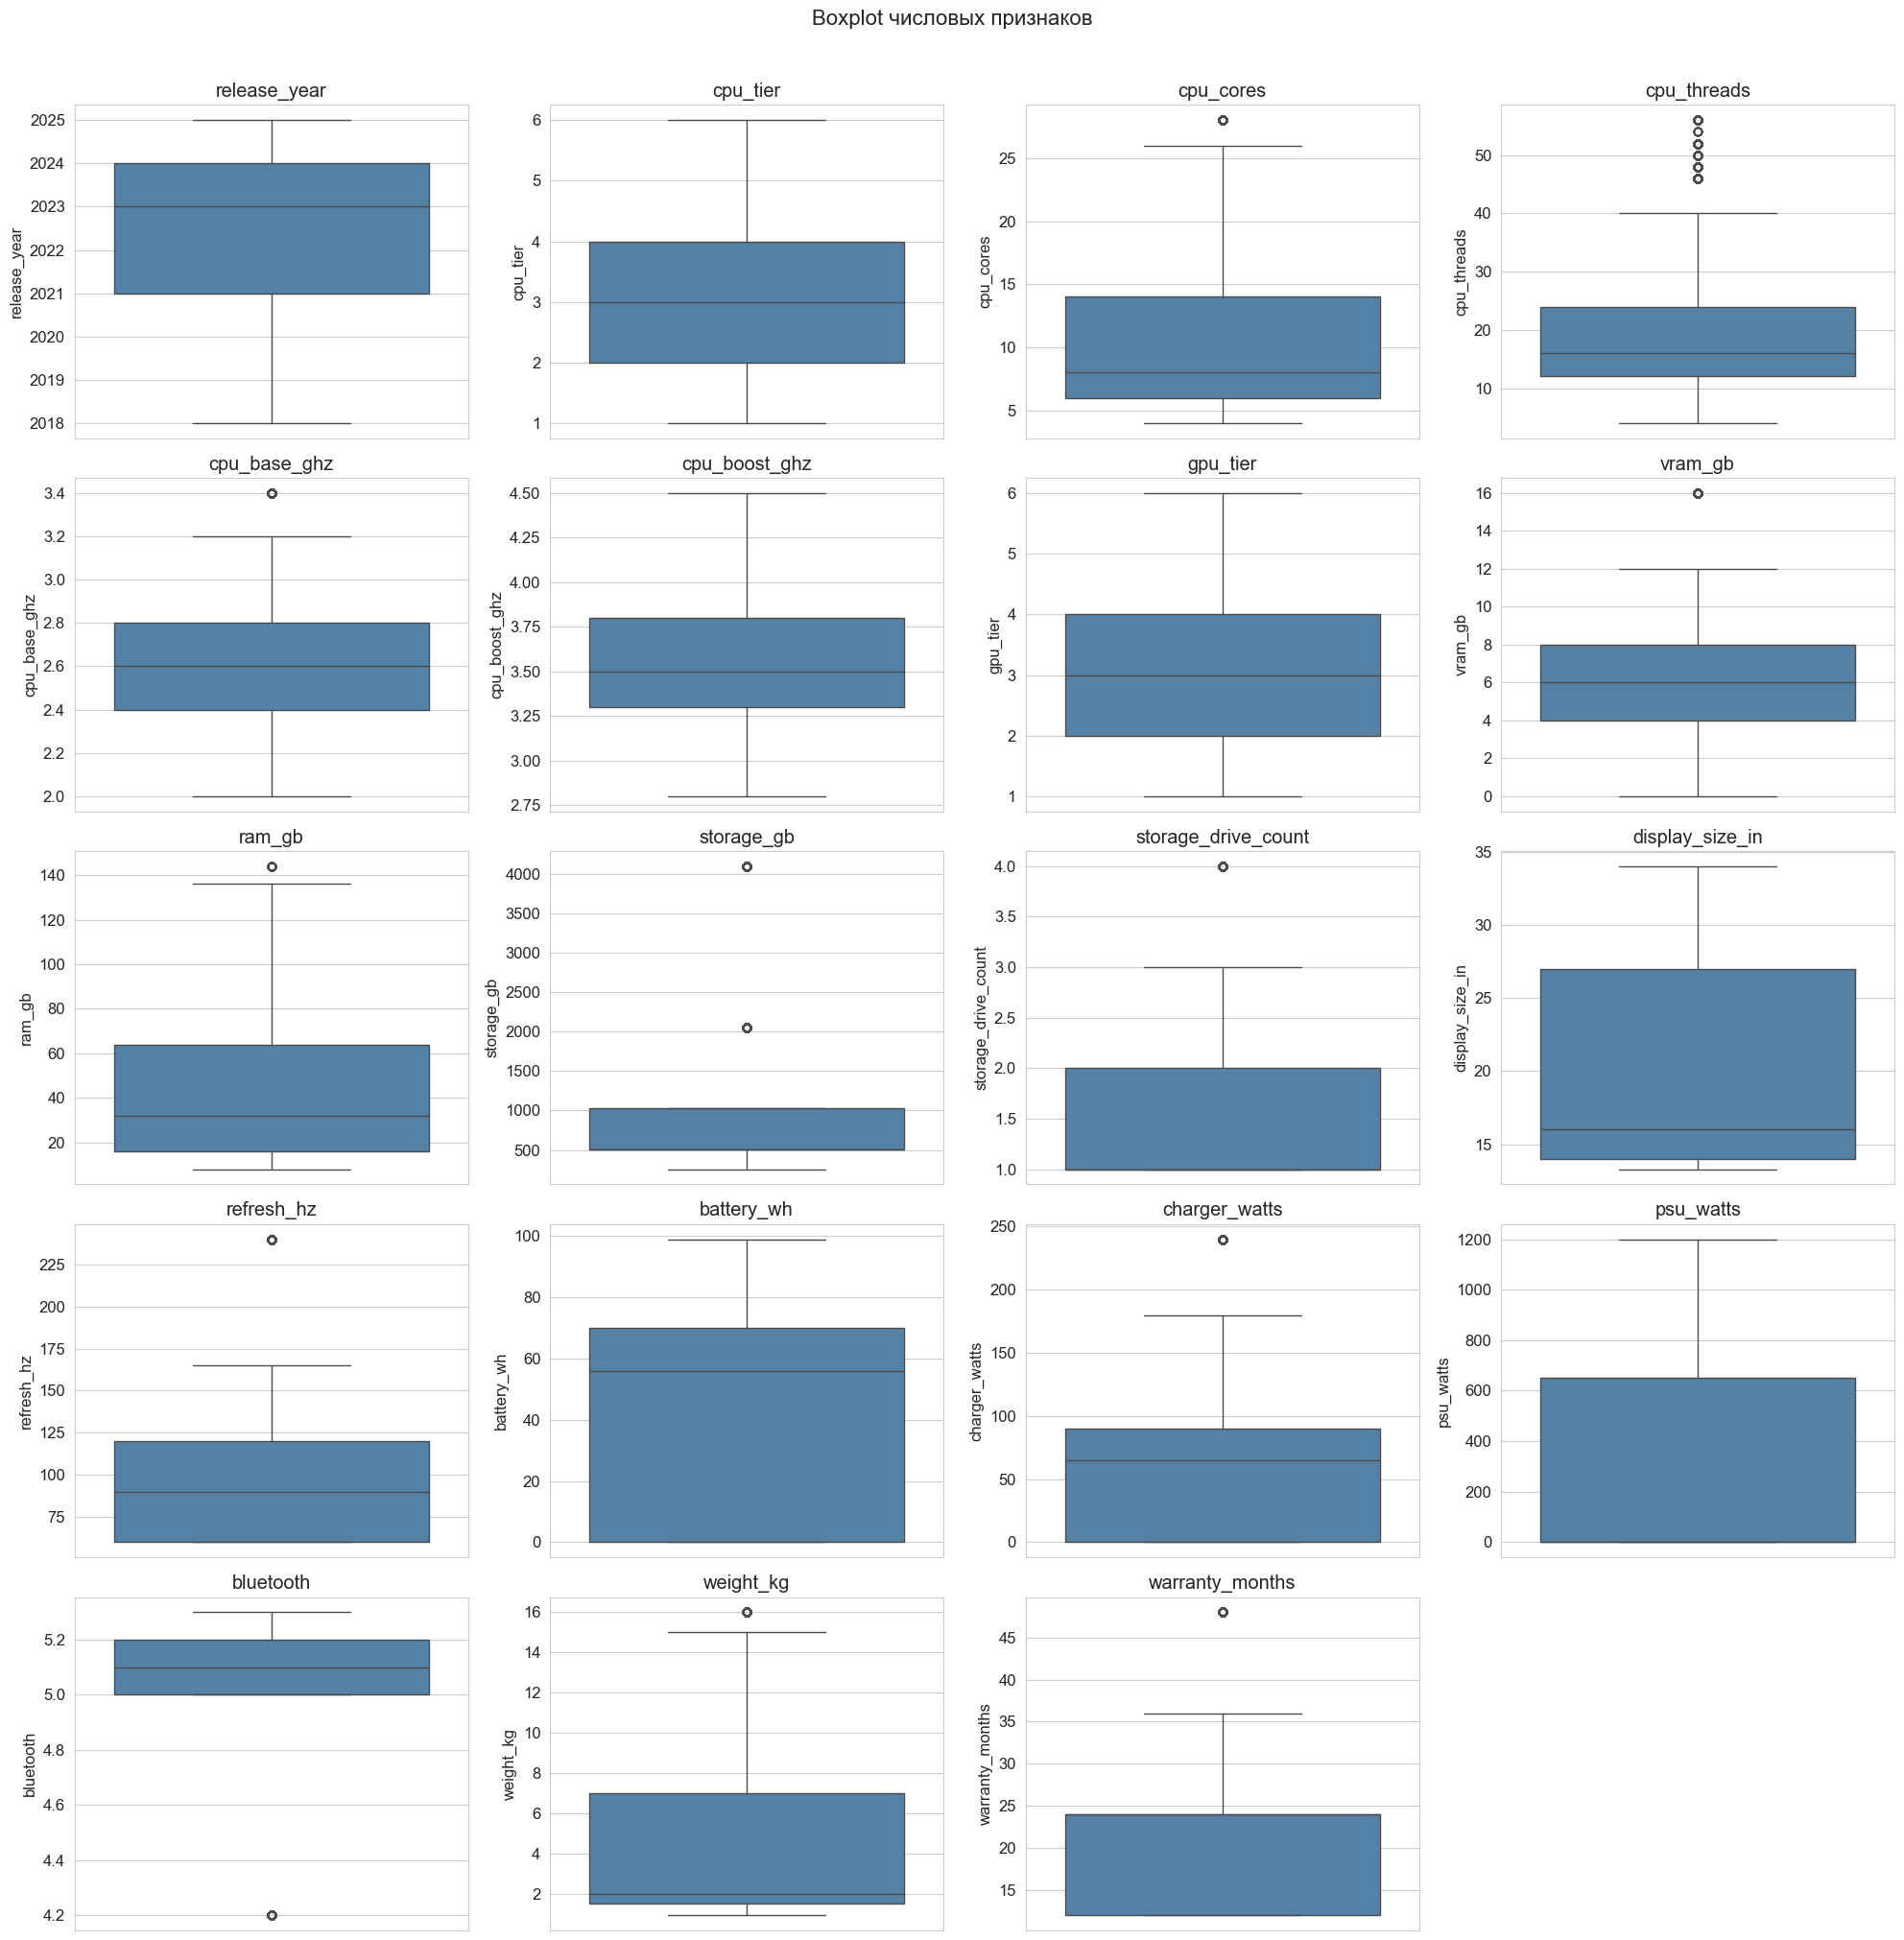

In [12]:
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

for i, col in enumerate(num_features):
    sns.boxplot(y=df[col], ax=axes[i], color='steelblue')
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Boxplot числовых признаков', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

Займемся проверкой некоторых выбросов

**weight_kg (вес)**:
Скорее всего большой вес имеется у Desktop, но на всякий случай проверим, нет ли ноутбуков с анамально большим весом

**battery_wh**:
Видно, что нижний ус входит в 0. Вероятнее всего это из-за того, что у нас имеются Desktop, у которых этот показатель 0. Но необходимо проверить,
нет ли ноутбуков с анамальными значениями

In [13]:
# weight_kg (вес)
df_weight = df[(df["weight_kg"] > 3.5) & (df["device_type"] == "Laptop")]
print(f"Количество аномальных значений веса у ноутбука: {df_weight.shape[0]}")

# battery_wh
df_battery = df[(df["battery_wh"] < 10) & (df["device_type"] == "Laptop")]
print(f"Количество аномальных значений емкости батареи у ноутбука: {df_battery.shape[0]}")

Количество аномальных значений веса у ноутбука: 0
Количество аномальных значений емкости батареи у ноутбука: 0


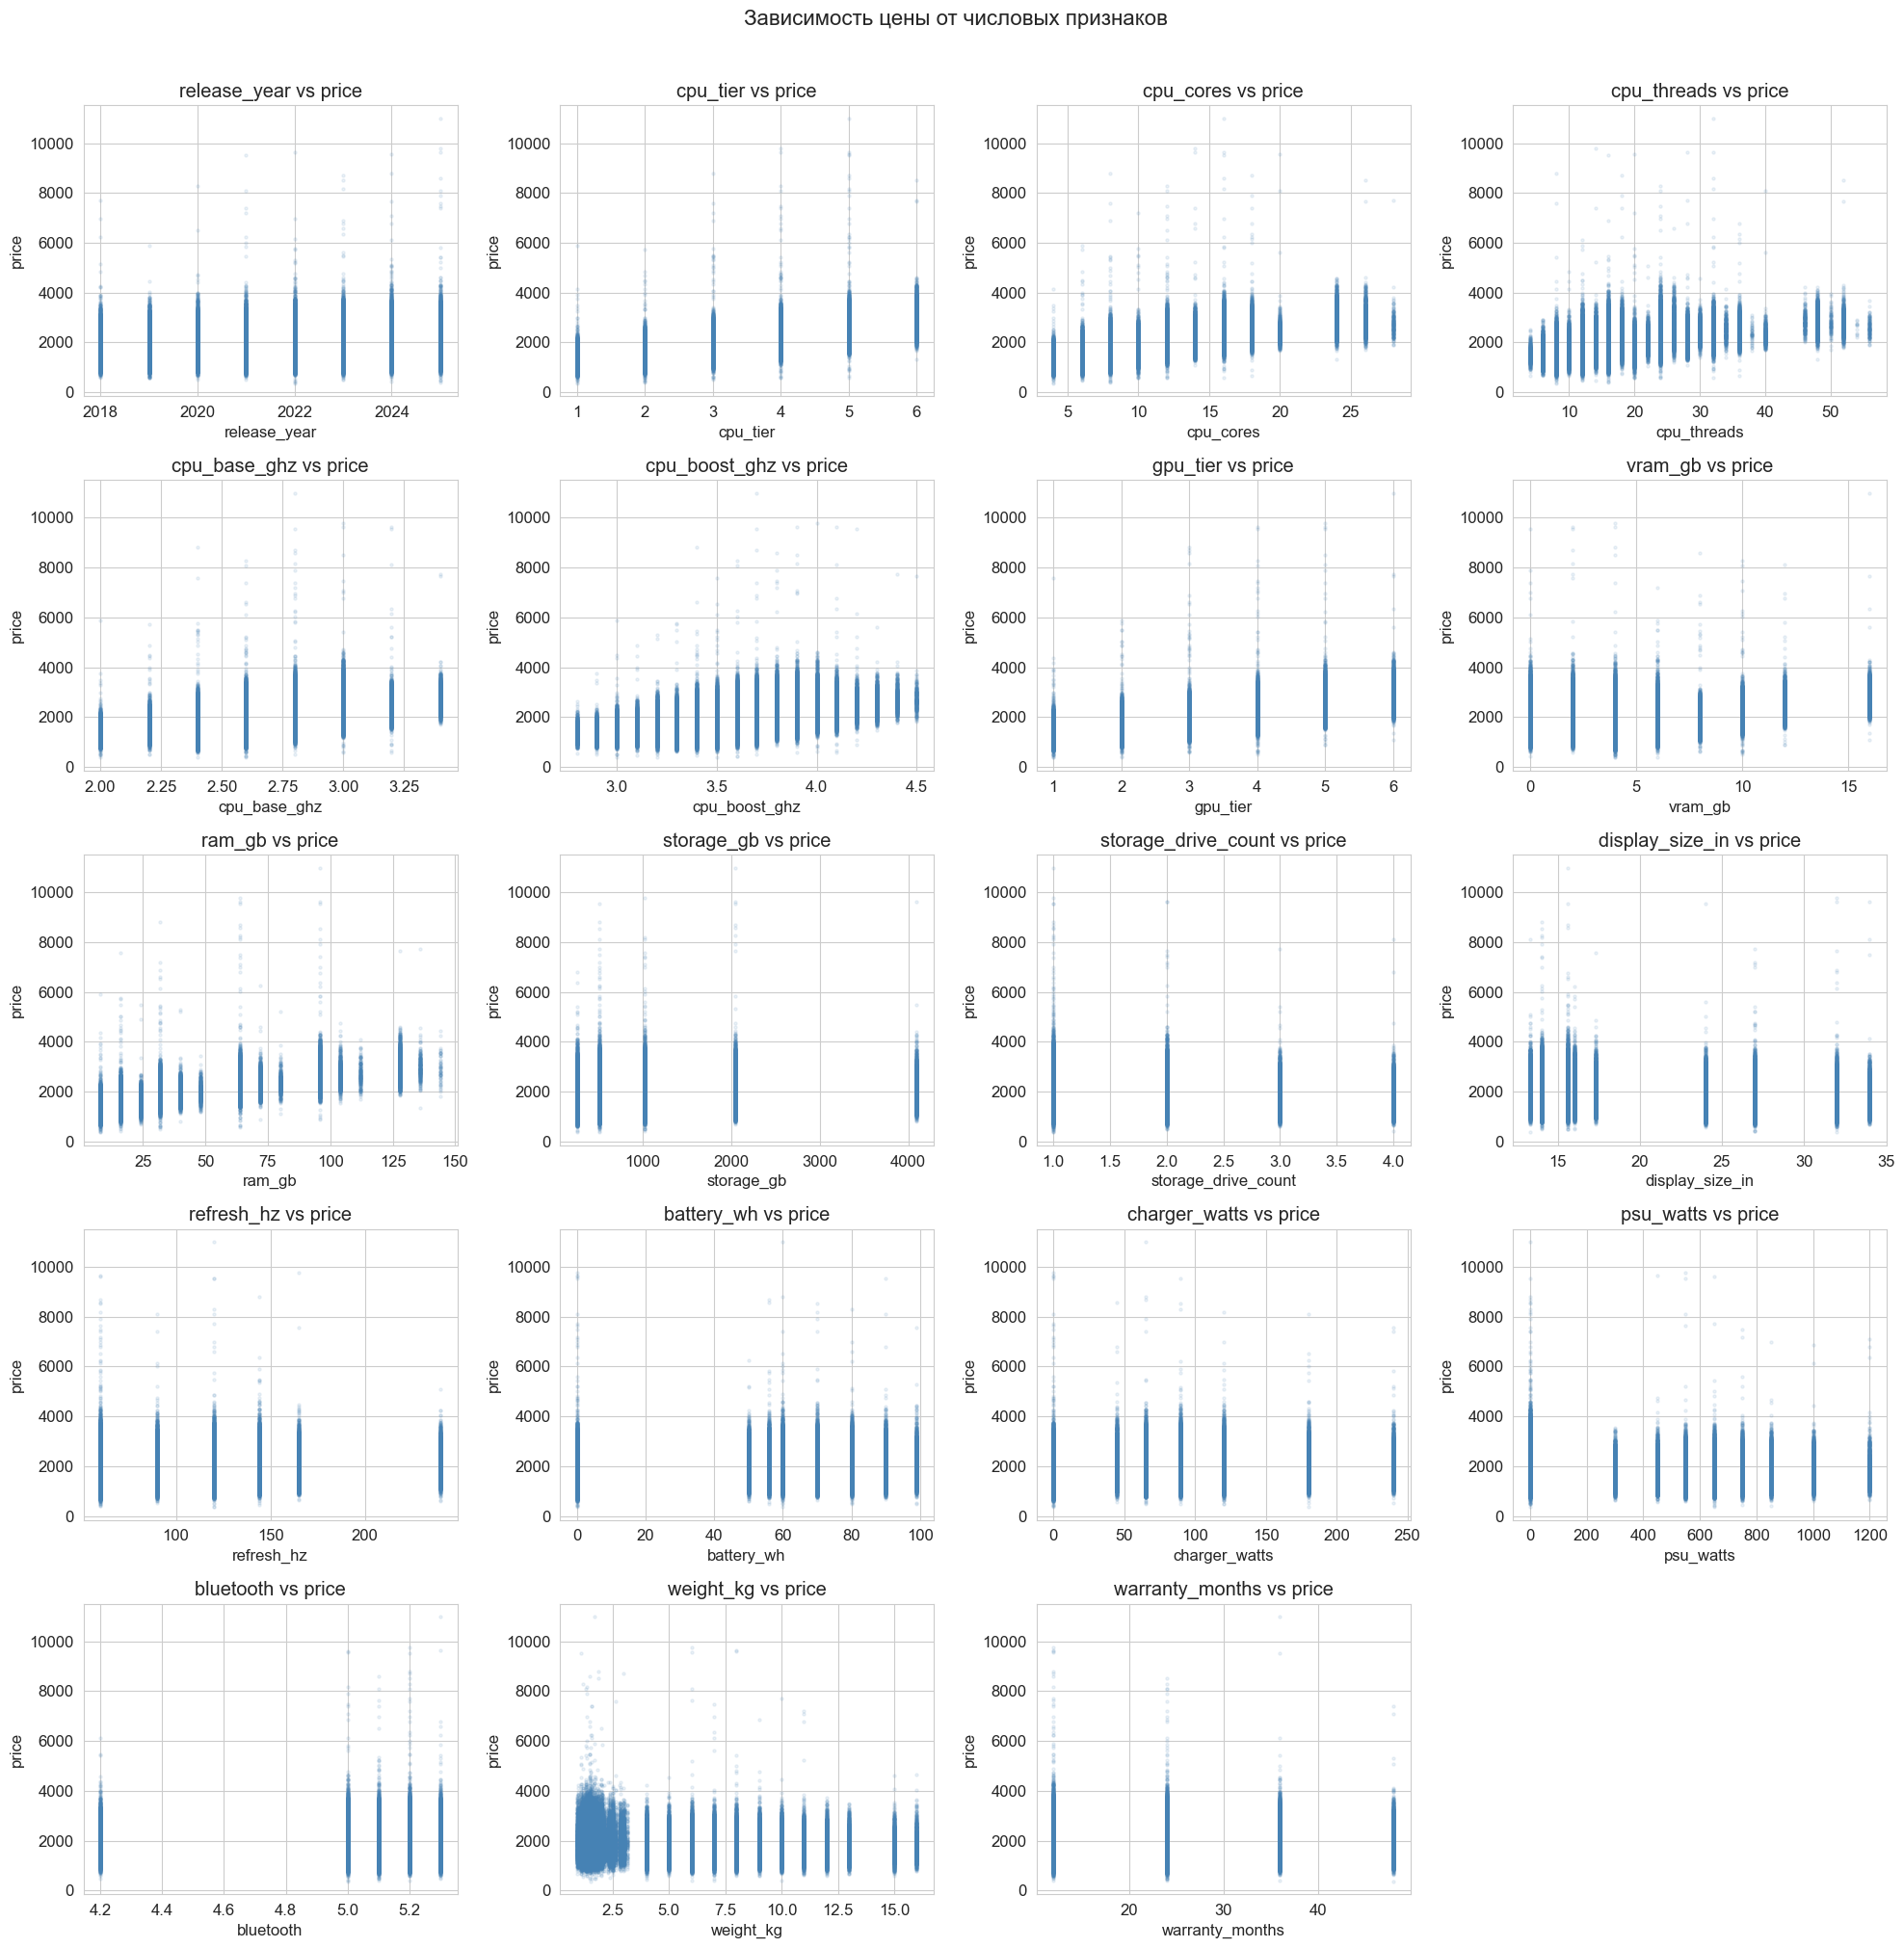

In [14]:
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

for i, col in enumerate(num_features):
    axes[i].scatter(df[col], df[target], alpha=0.1, s=5, color='steelblue')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(target)
    axes[i].set_title(f'{col} vs {target}')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Зависимость цены от числовых признаков', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

<a id='6'></a>
## 6. Анализ категориальных признаков

In [17]:
for col in cat_cols:
    print(f'{col} ({df[col].nunique()} уникальных):')
    print(df[col].value_counts().head(10))
    print()

device_type (2 уникальных):
device_type
Laptop     59844
Desktop    40156
Name: count, dtype: int64

brand (10 уникальных):
brand
Lenovo      15992
HP          14114
Dell        14005
Apple       11915
ASUS        10159
Acer         9925
Samsung      8066
MSI          7891
Gigabyte     4900
Razer        3033
Name: count, dtype: int64

model (99036 уникальных):
model
ASUS Slim R6S       3
Acer Creator 3U0    3
HP Creator R41      3
Samsung Pro HRZ     3
Lenovo Think 0V5    3
Dell Creator Y60    3
HP Pro K9S          3
Dell Think QJA      3
Apple Zen 4U3       2
HP Creator CMV      2
Name: count, dtype: int64

os (4 уникальных):
os
Windows     71817
macOS       18207
Linux        6109
ChromeOS     3867
Name: count, dtype: int64

form_factor (10 уникальных):
form_factor
Mainstream     17819
Gaming         16876
ATX            15597
Ultrabook      13236
Micro-ATX       8672
Full-Tower      7110
2-in-1          7049
SFF             5585
Workstation     4864
Mini-ITX        3192
Name: count,

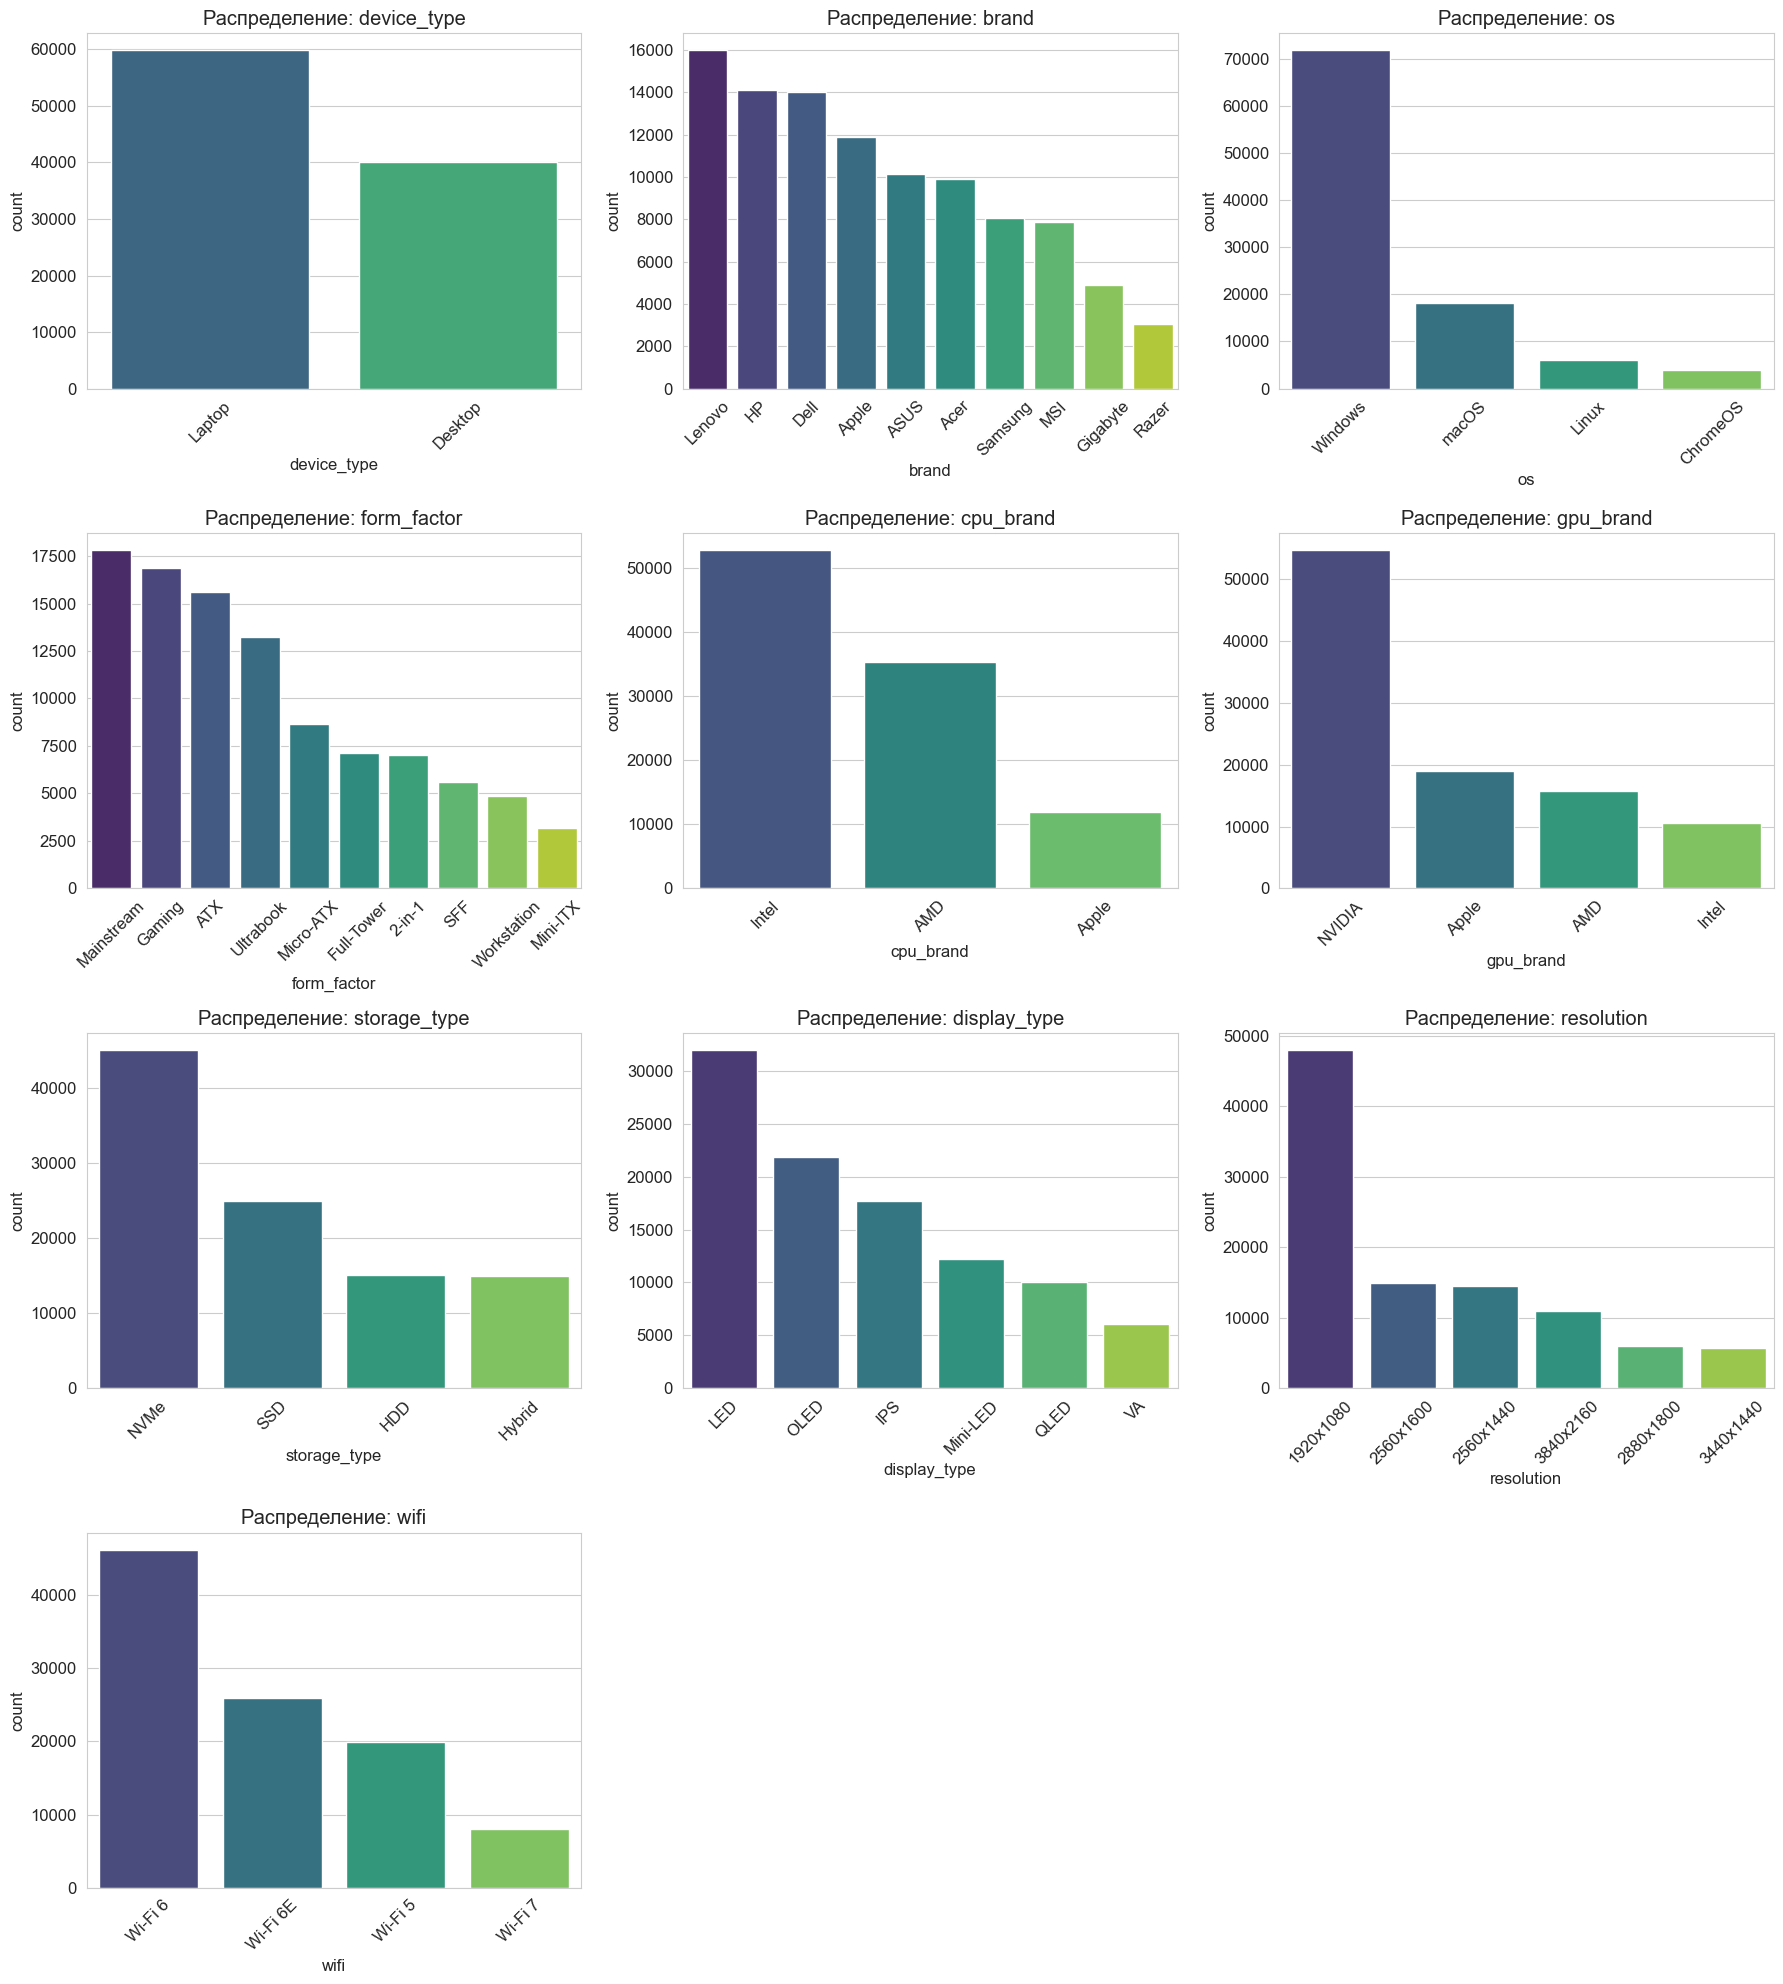

In [18]:
low_card_cats = [c for c in cat_cols if df[c].nunique() <= 15]

n_lc = len(low_card_cats)
ncols_lc = min(3, n_lc)
nrows_lc = (n_lc + ncols_lc - 1) // ncols_lc

fig, axes = plt.subplots(nrows_lc, ncols_lc, figsize=(6 * ncols_lc, 5 * nrows_lc))
if n_lc == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for i, col in enumerate(low_card_cats):
    order = df[col].value_counts().index
    sns.countplot(data=df, x=col, ax=axes[i], order=order, palette='viridis')
    axes[i].set_title(f'Распределение: {col}')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

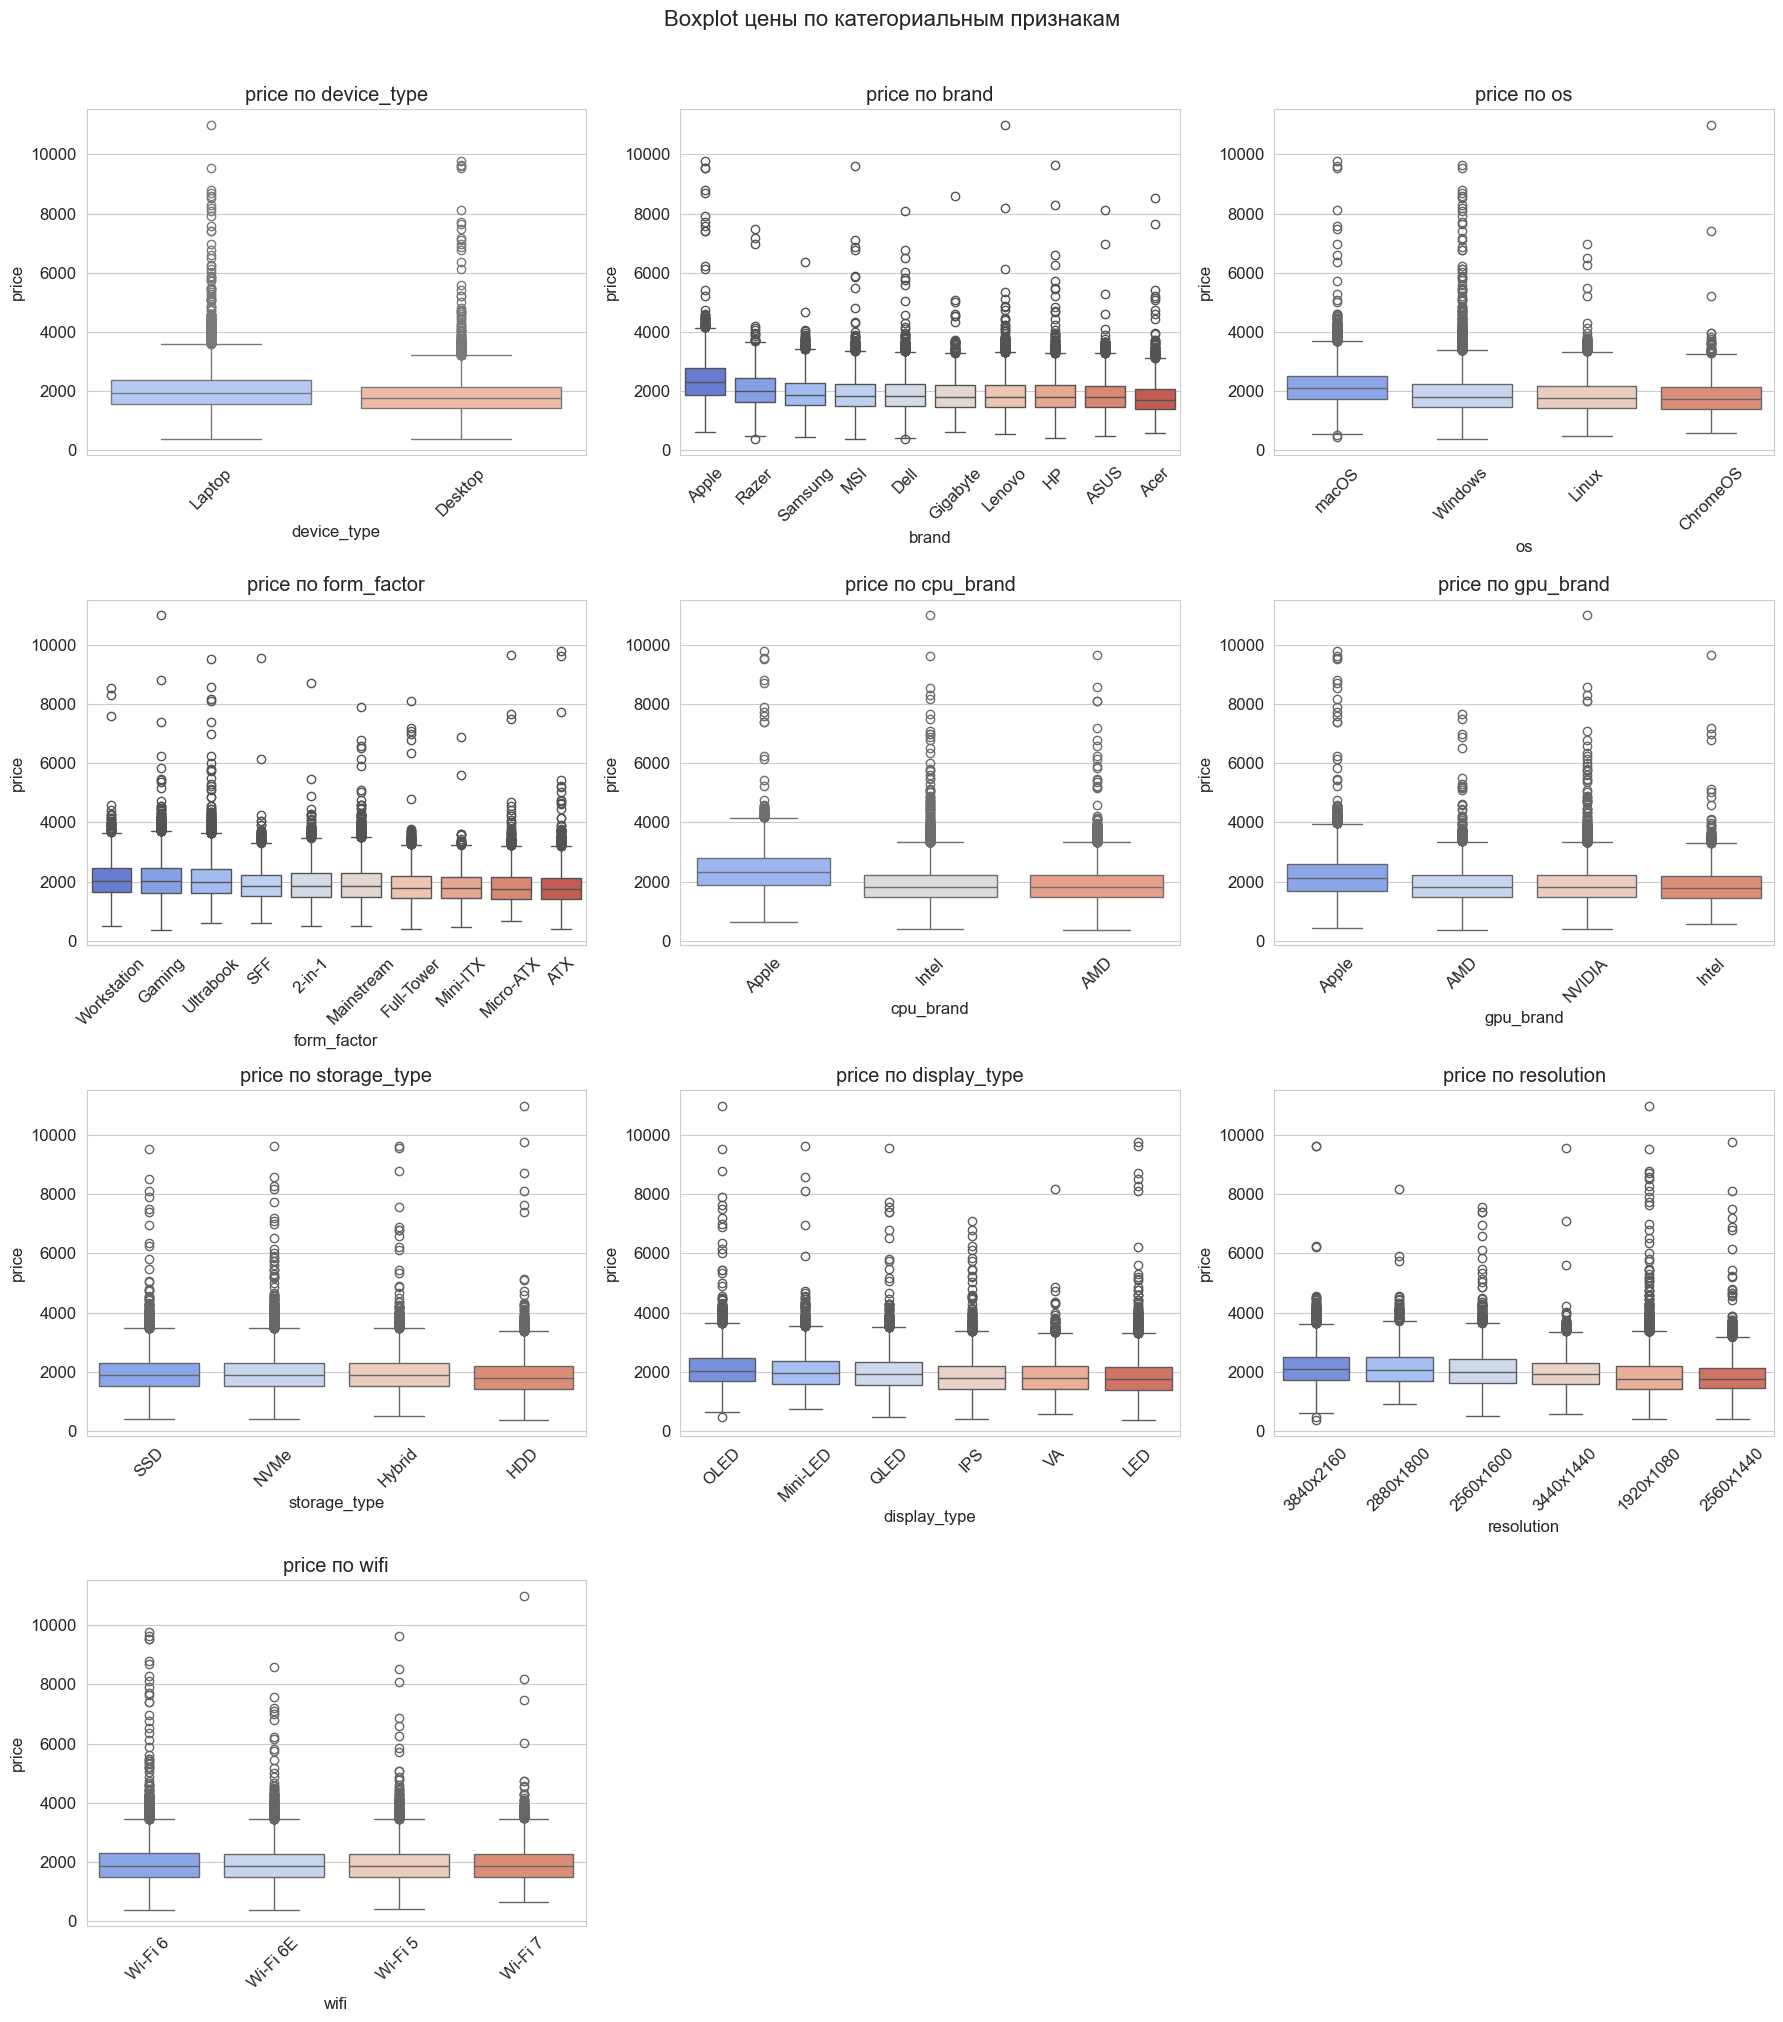

In [19]:
fig, axes = plt.subplots(nrows_lc, ncols_lc, figsize=(6 * ncols_lc, 5 * nrows_lc))
if n_lc == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for i, col in enumerate(low_card_cats):
    order = df.groupby(col)[target].median().sort_values(ascending=False).index
    sns.boxplot(data=df, x=col, y=target, ax=axes[i], order=order, palette='coolwarm')
    axes[i].set_title(f'{target} по {col}')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Boxplot цены по категориальным признакам', fontsize=16, y=1.01)
plt.tight_layout()

plt.show()

<a id='7'></a>
## 7. Корреляционный анализ

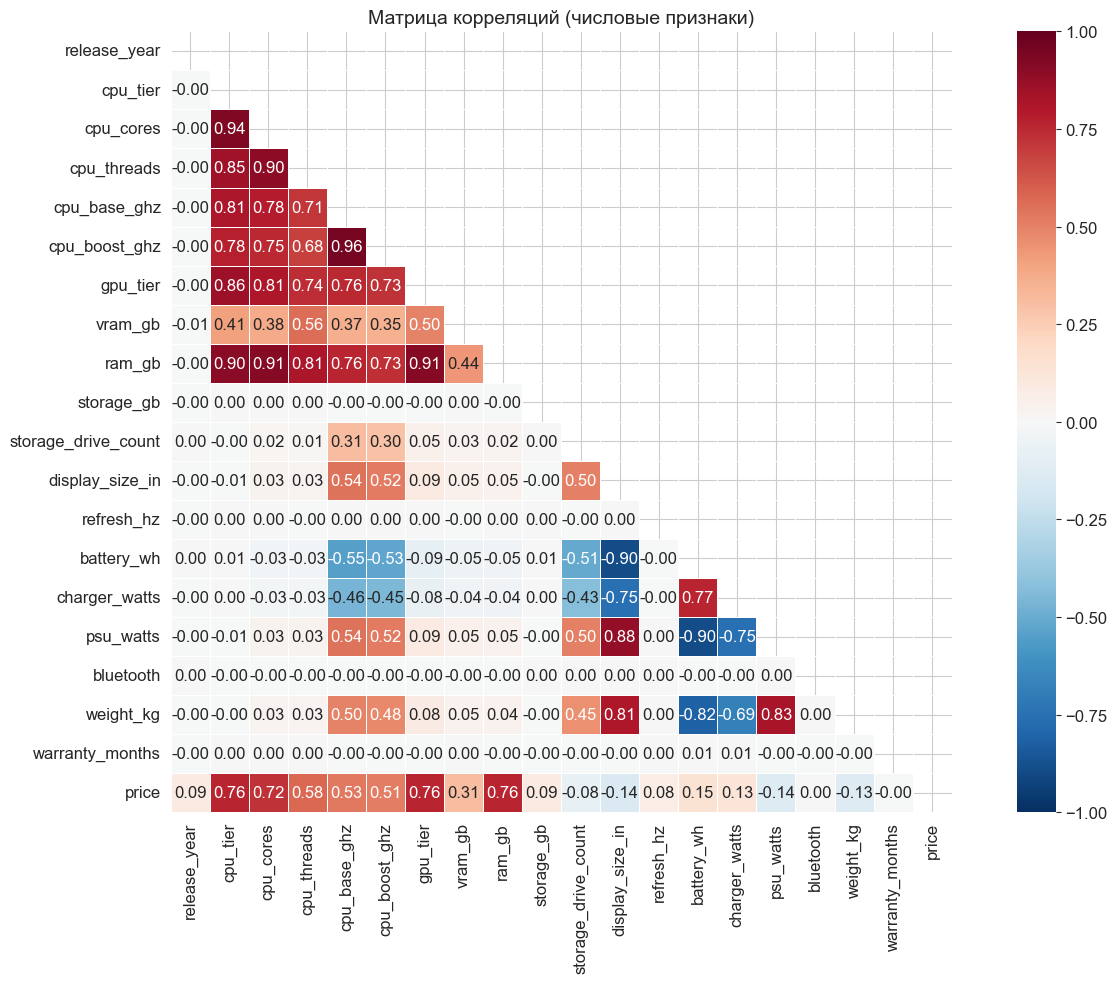

In [21]:
corr_matrix = df[num_cols].corr()

fig, ax = plt.subplots(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, ax=ax, square=True, linewidths=0.5)
ax.set_title('Матрица корреляций (числовые признаки)', fontsize=14)
plt.tight_layout()
plt.savefig('my_plot1.png', dpi=300, bbox_inches='tight') 
plt.show()

# НАБЛЮДЕНИЕ
ram_gb, cpu_tier, gpu_tier, cpu_cores - хорошо коррелируют с "price"

Удаляем (в рамках feature engineering) из-за мультиколлениарности:
cpu_threads, cpu_boost_ghz, cpu_tier, battery_wh, charger_watts, psu_watts

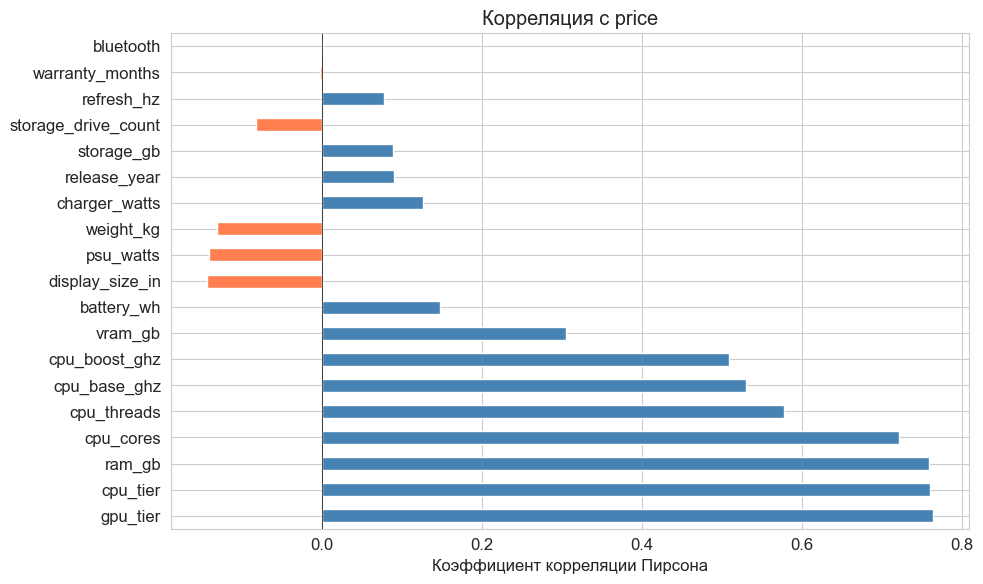

In [17]:
target_corr = corr_matrix[target].drop(target).sort_values(key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['steelblue' if v > 0 else 'coral' for v in target_corr.values]
target_corr.plot(kind='barh', ax=ax, color=colors)
ax.set_title(f'Корреляция с {target}')
ax.set_xlabel('Коэффициент корреляции Пирсона')
ax.axvline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

<a id='8'></a>
## 8. Выбросы

In [18]:
def count_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).sum()

print('Количество выбросов (IQR-метод):')
for col in num_cols:
    n_out = count_outliers_iqr(df[col].dropna())
    if n_out > 0:
        print(f'  {col}: {n_out} ({n_out / len(df) * 100:.1f}%)')

Количество выбросов (IQR-метод):
  cpu_cores: 200 (0.2%)
  cpu_threads: 3551 (3.6%)
  cpu_base_ghz: 1978 (2.0%)
  vram_gb: 3328 (3.3%)
  ram_gb: 60 (0.1%)
  storage_gb: 14811 (14.8%)
  storage_drive_count: 4041 (4.0%)
  refresh_hz: 2913 (2.9%)
  charger_watts: 3039 (3.0%)
  bluetooth: 5939 (5.9%)
  weight_kg: 1031 (1.0%)
  warranty_months: 5007 (5.0%)
  price: 976 (1.0%)


<a id='9'></a>
## 9. Feature Engineering

In [24]:
df_model = df.copy()

# Парсим разрешение экрана в ширину и высоту
if 'resolution' in df_model.columns:
    res_split = df_model['resolution'].str.split('x', expand=True)
    df_model['res_width'] = pd.to_numeric(res_split[0], errors='coerce')
    df_model['res_height'] = pd.to_numeric(res_split[1], errors='coerce')
    df_model['total_pixels'] = df_model['res_width'] * df_model['res_height']
    df_model.drop(columns=['resolution'], inplace=True)

# Удаляем столбцы с высокой кардинальностью (модель, cpu_model, gpu_model)
high_card_cols = ["model", "cpu_model"]
print(f'Удаляем столбцы с высокой кардинальностью: {high_card_cols}')
df_model.drop(columns=high_card_cols, inplace=True, errors='ignore')

# Удаляем столбцы, которые имеют мультиколлениарность с другими столбцами.
multikoll_cols = ["cpu_threads", "cpu_boost_ghz", "cpu_tier", "battery_wh", "charger_watts", "psu_watts"]
print(f'Удаляем мультиколлениарные столбцы: {multikoll_cols}')
df_model.drop(columns=multikoll_cols, inplace=True, errors='ignore')

print(f'\nИтоговая форма: {df_model.shape}')
df_model.head()

Удаляем столбцы с высокой кардинальностью: ['model', 'cpu_model']
Удаляем мультиколлениарные столбцы: ['cpu_threads', 'cpu_boost_ghz', 'cpu_tier', 'battery_wh', 'charger_watts', 'psu_watts']

Итоговая форма: (100000, 27)


,device_type,brand,release_year,os,form_factor,cpu_brand,cpu_cores,cpu_base_ghz,gpu_brand,gpu_model,...,display_size_in,refresh_hz,wifi,bluetooth,weight_kg,warranty_months,price,res_width,res_height,total_pixels
0,Desktop,Samsung,2022,Windows,ATX,Intel,12,2.8,NVIDIA,RTX 40 60,...,27.0,90,Wi-Fi 6,5.1,11.00,36,1383.99,2560,1440,3686400
1,Laptop,Samsung,2022,Windows,Mainstream,Intel,12,2.6,NVIDIA,RTX 40 80,...,16.0,90,Wi-Fi 6,5.3,2.03,12,2274.99,1920,1080,2073600
2,Desktop,Lenovo,2024,macOS,SFF,AMD,8,2.6,NVIDIA,RTX 40 50,...,32.0,120,Wi-Fi 6,5.0,7.00,24,1879.99,3440,1440,4953600
3,Desktop,Dell,2024,Windows,ATX,AMD,6,2.6,AMD,RX 7000 60,...,27.0,120,Wi-Fi 6,5.2,6.00,36,1331.99,3440,1440,4953600
4,Laptop,Gigabyte,2024,Linux,Gaming,AMD,16,2.8,NVIDIA,RTX 30 80 Ti,...,15.6,90,Wi-Fi 6,5.2,1.50,12,2681.99,2560,1600,4096000


<a id='10'></a>
## 10. Подготовка данных для моделирования

In [25]:
X = df_model.drop(columns=[target])
y = df_model[target]
y_log = np.log(df_model[target])

cat_features = X.select_dtypes(include='object').columns.tolist()
num_features_final = X.select_dtypes(include=[np.number]).columns.tolist()

print(f'Категориальные для кодирования: {cat_features}')
print()
print(f'Числовые: {num_features_final}')

Категориальные для кодирования: ['device_type', 'brand', 'os', 'form_factor', 'cpu_brand', 'gpu_brand', 'gpu_model', 'storage_type', 'display_type', 'wifi']

Числовые: ['release_year', 'cpu_cores', 'cpu_base_ghz', 'gpu_tier', 'vram_gb', 'ram_gb', 'storage_gb', 'storage_drive_count', 'display_size_in', 'refresh_hz', 'bluetooth', 'weight_kg', 'warranty_months', 'res_width', 'res_height', 'total_pixels']


In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features_final),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
    ]
)

# Чистые данные
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Прологорифмировоанный price
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=RANDOM_STATE
)

print(f'Train: {X_train.shape}, Test: {X_test.shape}')
print(f'Train_log: {X_train_log.shape}, Test_log: {X_test_log.shape}')

Train: (80000, 26), Test: (20000, 26)
Train_log: (80000, 26), Test_log: (20000, 26)


<a id='11'></a>
## 11. Модели: LinearRegression, Lasso, Ridge, DecisionTreeRegressor

In [33]:
def evaluate_model(model, isLog, X_tr, y_tr, X_te, y_te):
    """Обучает модель и возвращает метрики на train и test."""
    model.fit(X_tr, y_tr)

    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_te)
    
    if isLog:
        y_pred_train = np.exp(y_pred_train)
        y_pred_test = np.exp(y_pred_test)
        y_tr_orig = np.exp(y_tr)
        y_te_orig = np.exp(y_te)
        
    else:
        y_tr_orig = y_tr
        y_te_orig = y_te
        
        
    metrics = {
        'R2_train': r2_score(y_tr_orig, y_pred_train),
        'R2_test': r2_score(y_te_orig, y_pred_test),
        'RMSE_train': np.sqrt(mean_squared_error(y_tr_orig, y_pred_train)),
        'RMSE_test': np.sqrt(mean_squared_error(y_te_orig, y_pred_test)),
        'MAE_train': mean_absolute_error(y_tr_orig, y_pred_train),
        'MAE_test': mean_absolute_error(y_te_orig, y_pred_test),
        'MAPE_test': mean_absolute_percentage_error(y_te_orig, y_pred_test),
    }
    return metrics, y_pred_test

In [34]:
models = {
    'LinearRegression': Pipeline([
        ('prep', preprocessor),
        ('model', LinearRegression())
    ]),
    'Lasso (alpha=1.0)': Pipeline([
        ('prep', preprocessor),
        ('model', Lasso(alpha=1.0, random_state=RANDOM_STATE, max_iter=10000))
    ]),
    'Ridge (alpha=1.0)': Pipeline([
        ('prep', preprocessor),
        ('model', Ridge(alpha=1.0, random_state=RANDOM_STATE))
    ]),
    'DecisionTree (default)': Pipeline([
        ('prep', preprocessor),
        ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]),
}

results = {}
predictions = {}

results_log = {}
predictions_log = {}

for name, pipe in models.items():
    metrics, y_pred = evaluate_model(pipe, False, X_train, y_train, X_test, y_test)
    metrics_log, y_pred_log = evaluate_model(pipe, True, X_train_log, y_train_log, X_test_log, y_test_log)
    
    results[name] = metrics
    predictions[name] = y_pred
    results_log[name] = metrics_log
    predictions_log[name] = y_pred_log
    
    print(f'--- {name} ---')
    for k, v in metrics.items():
        print(f'  {k}: {v:.4f}')
    print()

    print(f'--- {name}_log ---')
    for k, v in metrics_log.items():
        print(f'  {k}: {v:.4f}')
    print()

--- LinearRegression ---
  R2_train: 0.8485
  R2_test: 0.8749
  RMSE_train: 226.5433
  RMSE_test: 203.2808
  MAE_train: 145.2514
  MAE_test: 143.6065
  MAPE_test: 0.0769

--- LinearRegression_log ---
  R2_train: 0.8415
  R2_test: 0.8685
  RMSE_train: 231.6541
  RMSE_test: 208.4188
  MAE_train: 148.2889
  MAE_test: 146.5460
  MAPE_test: 0.0775

--- Lasso (alpha=1.0) ---
  R2_train: 0.8459
  R2_test: 0.8726
  RMSE_train: 228.4809
  RMSE_test: 205.1026
  MAE_train: 146.7736
  MAE_test: 145.1715
  MAPE_test: 0.0777

--- Lasso (alpha=1.0)_log ---
  R2_train: -0.0206
  R2_test: -0.0208
  RMSE_train: 587.9189
  RMSE_test: 580.5865
  MAE_train: 456.2128
  MAE_test: 456.2963
  MAPE_test: 0.2514

--- Ridge (alpha=1.0) ---
  R2_train: 0.8485
  R2_test: 0.8749
  RMSE_train: 226.5433
  RMSE_test: 203.2781
  MAE_train: 145.2495
  MAE_test: 143.6044
  MAPE_test: 0.0769

--- Ridge (alpha=1.0)_log ---
  R2_train: 0.8415
  R2_test: 0.8685
  RMSE_train: 231.6512
  RMSE_test: 208.4131
  MAE_train: 148.286

In [36]:
results_df = pd.DataFrame(results).T
display(results_df.style.set_caption("Чистые данные").highlight_min(
    subset=['RMSE_test', 'MAE_test', 'MAPE_test'], color='lightgreen'
).highlight_max(
    subset=['R2_test'], color='lightgreen'
))

results_df_log = pd.DataFrame(results_log).T
display(results_df_log.style.set_caption("Логарифмированные данные").highlight_min(
    subset=['RMSE_test', 'MAE_test', 'MAPE_test'], color='lightgreen'
).highlight_max(
    subset=['R2_test'], color='lightgreen'
))

,R2_train,R2_test,RMSE_train,RMSE_test,MAE_train,MAE_test,MAPE_test
LinearRegression,0.848455,0.874860,226.543281,203.280779,145.251374,143.606471,0.076906
Lasso (alpha=1.0),0.845851,0.872607,228.480926,205.102600,146.773568,145.171487,0.077680
Ridge (alpha=1.0),0.848455,0.874863,226.543344,203.278071,145.249514,143.604355,0.076905
DecisionTree (default),1.000000,0.579360,0.000000,372.694743,0.000000,232.726550,0.123325


,R2_train,R2_test,RMSE_train,RMSE_test,MAE_train,MAE_test,MAPE_test
LinearRegression,0.841540,0.868454,231.654103,208.418754,148.288922,146.546044,0.077460
Lasso (alpha=1.0),-0.020646,-0.020794,587.918886,580.586520,456.212832,456.296302,0.251353
Ridge (alpha=1.0),0.841544,0.868461,231.651203,208.413060,148.286664,146.541963,0.077459
DecisionTree (default),1.000000,0.620179,0.000000,354.150230,0.000000,231.980650,0.123119


# НАБЛЮДЕНИЕ
1. В обоих случаях лучшей моделью оказалась Ridge регрессия (зеленые ячейки).
На «чистых» данных метрики чуть-чуть лучше, чем на логарифмированных.
2. Lasso во второй таблице стал отрицательным, а ошибки (RMSE, MAE) взлетели.
Lasso с параметром alpha=1.0 оказалось слишком агрессивным для логарифмированных признаков и просто «занулило» почти все веса. Для логарифмов здесь нужно подбирать другой alpha.
3. Переобучение Decision Tree
У решающего дерева (Decision Tree) на трейне идеальный $R^2$, а на тесте $R^2$ — провал.
Это переобучение. 
4. Адекватность метрик

В дальнейшем логарифмированные данные рассматривать не будем, так как оно не дало желаемых результатов.

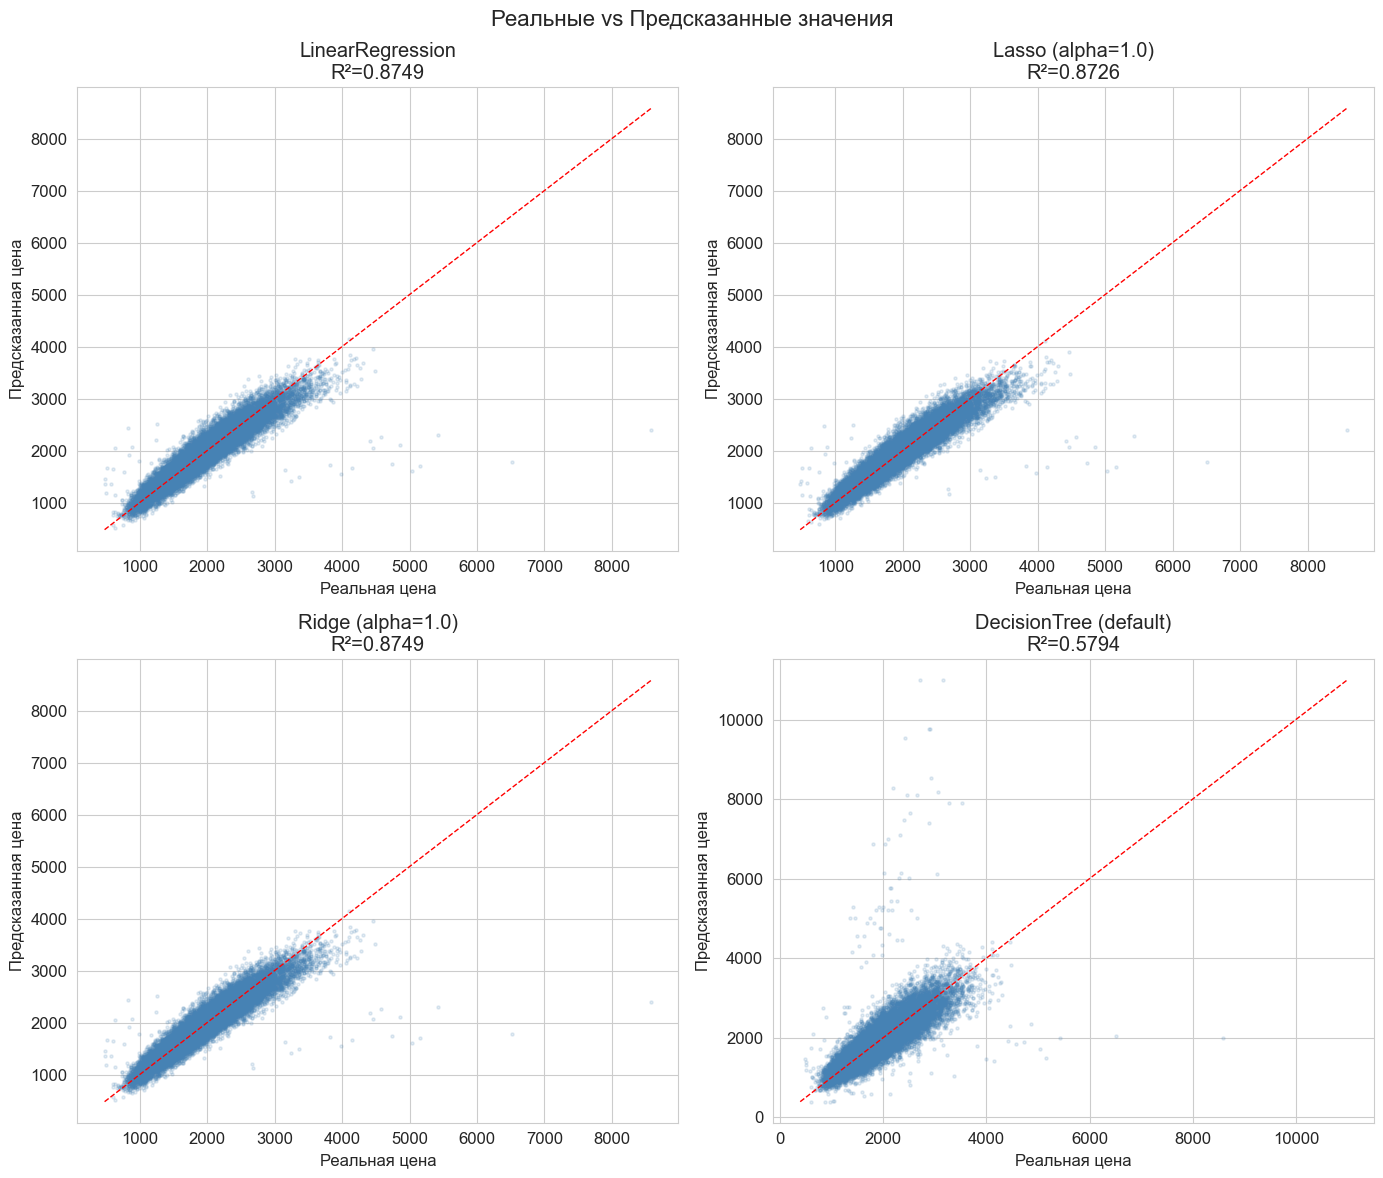

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, (name, y_pred) in enumerate(predictions.items()):
    ax = axes[i]
    ax.scatter(y_test, y_pred, alpha=0.15, s=5, color='steelblue')
    lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
    ax.plot(lims, lims, 'r--', linewidth=1)
    ax.set_xlabel('Реальная цена')
    ax.set_ylabel('Предсказанная цена')
    ax.set_title(f'{name}\nR²={results[name]["R2_test"]:.4f}')

plt.suptitle('Реальные vs Предсказанные значения', fontsize=16)
plt.tight_layout()
plt.show()

<a id='12'></a>
## 12. Кросс-валидация для оценки качества

In [40]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results = {}

for name, pipe in models.items():
    scores_r2 = cross_val_score(pipe, X, y, cv=kf, scoring='r2')
    scores_neg_rmse = cross_val_score(pipe, X, y, cv=kf, scoring='neg_root_mean_squared_error')
    scores_neg_mae = cross_val_score(pipe, X, y, cv=kf, scoring='neg_mean_absolute_error')
    
    cv_results[name] = {
        'R2_mean': scores_r2.mean(),
        'R2_std': scores_r2.std(),
        'RMSE_mean': -scores_neg_rmse.mean(),
        'RMSE_std': scores_neg_rmse.std(),
        'MAE_mean': -scores_neg_mae.mean(),
        'MAE_std': scores_neg_mae.std(),
    }
    print(f'--- {name} ---')
    print(f'  R²:   {scores_r2.mean():.4f} ± {scores_r2.std():.4f}')
    print(f'  RMSE: {-scores_neg_rmse.mean():.2f} ± {scores_neg_rmse.std():.2f}')
    print(f'  MAE:  {-scores_neg_mae.mean():.2f} ± {scores_neg_mae.std():.2f}')
    print()

cv_df = pd.DataFrame(cv_results).T
display(cv_df)

--- LinearRegression ---
  R²:   0.8539 ± 0.0226
  RMSE: 221.46 ± 19.39
  MAE:  145.03 ± 1.52

--- Lasso (alpha=1.0) ---
  R²:   0.8515 ± 0.0227
  RMSE: 223.28 ± 19.40
  MAE:  146.51 ± 1.46

--- Ridge (alpha=1.0) ---
  R²:   0.8539 ± 0.0226
  RMSE: 221.46 ± 19.39
  MAE:  145.03 ± 1.52

--- DecisionTree (default) ---
  R²:   0.6414 ± 0.0260
  RMSE: 347.37 ± 13.32
  MAE:  229.70 ± 2.44



,R2_mean,R2_std,RMSE_mean,RMSE_std,MAE_mean,MAE_std
LinearRegression,0.853882,0.022553,221.457040,19.389509,145.032686,1.521045
Lasso (alpha=1.0),0.851482,0.022708,223.278502,19.396773,146.510090,1.455131
Ridge (alpha=1.0),0.853883,0.022554,221.456628,19.390401,145.031027,1.521450
DecisionTree (default),0.641375,0.025978,347.371738,13.318235,229.699080,2.441644


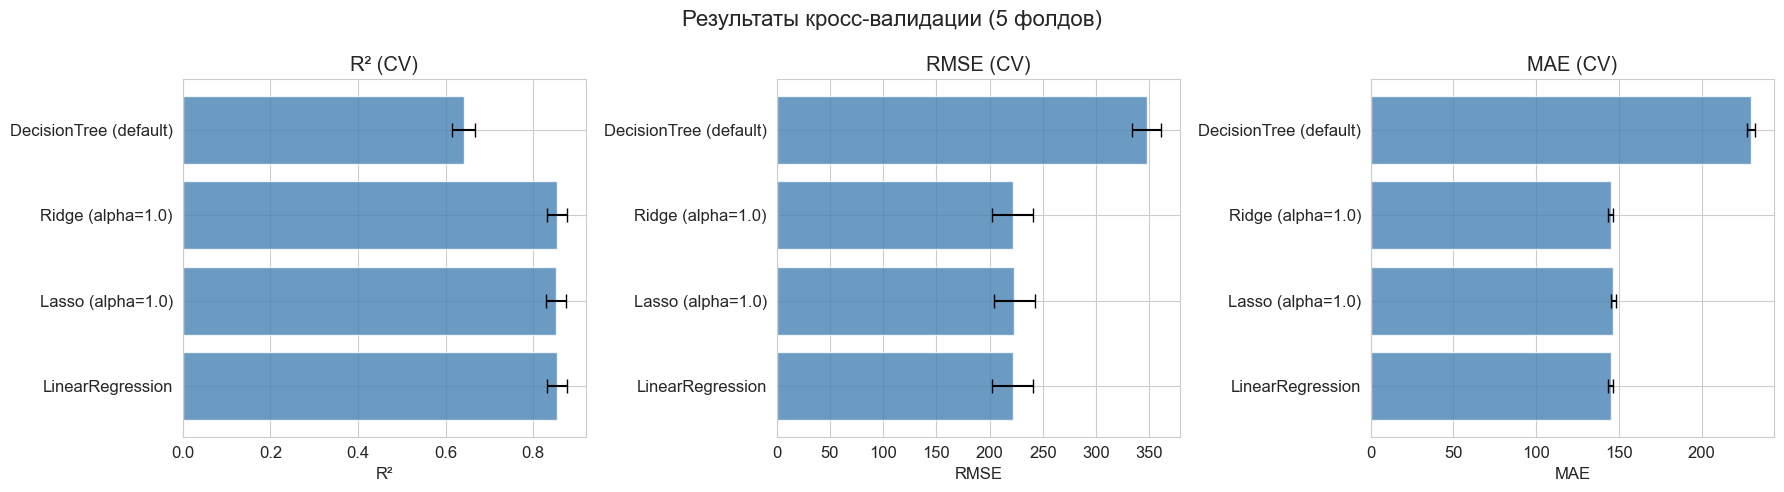

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = [
    ('R2_mean', 'R2_std', 'R² (CV)'),
    ('RMSE_mean', 'RMSE_std', 'RMSE (CV)'),
    ('MAE_mean', 'MAE_std', 'MAE (CV)'),
]

for ax, (mean_col, std_col, title) in zip(axes, metrics_to_plot):
    names = cv_df.index.tolist()
    means = cv_df[mean_col].values
    stds = cv_df[std_col].values
    
    bars = ax.barh(names, means, xerr=stds, color='steelblue', alpha=0.8, capsize=5)
    ax.set_title(title)
    ax.set_xlabel(title.split(' ')[0])

plt.suptitle('Результаты кросс-валидации (5 фолдов)', fontsize=16)
plt.tight_layout()
plt.show()

<a id='13'></a>
## 13. Подбор гиперпараметров (GridSearchCV)

### 13.1 Lasso: подбор alpha
Кросс-валидация помогает найти оптимальное значение регуляризации — **веса** штрафного члена.

In [44]:
print("Подбор alpha начат")

lasso_pipe = Pipeline([
    ('prep', preprocessor),
    ('model', Lasso(random_state=RANDOM_STATE, max_iter=10000))
])

lasso_params = {
    'model__alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
}

lasso_gs = GridSearchCV(
    lasso_pipe, lasso_params, cv=kf, scoring='r2', 
    return_train_score=True, n_jobs=-1
)
lasso_gs.fit(X_train, y_train)

print("Подбор alpha закончен")

print(f'Лучший alpha для Lasso: {lasso_gs.best_params_}')
print(f'Лучший R² (CV): {lasso_gs.best_score_:.4f}')
print(f'R² на тесте: {lasso_gs.score(X_test, y_test):.4f}')

Подбор alpha начат
Подбор alpha закончен
Лучший alpha для Lasso: {'model__alpha': 0.001}
Лучший R² (CV): 0.8483
R² на тесте: 0.8749


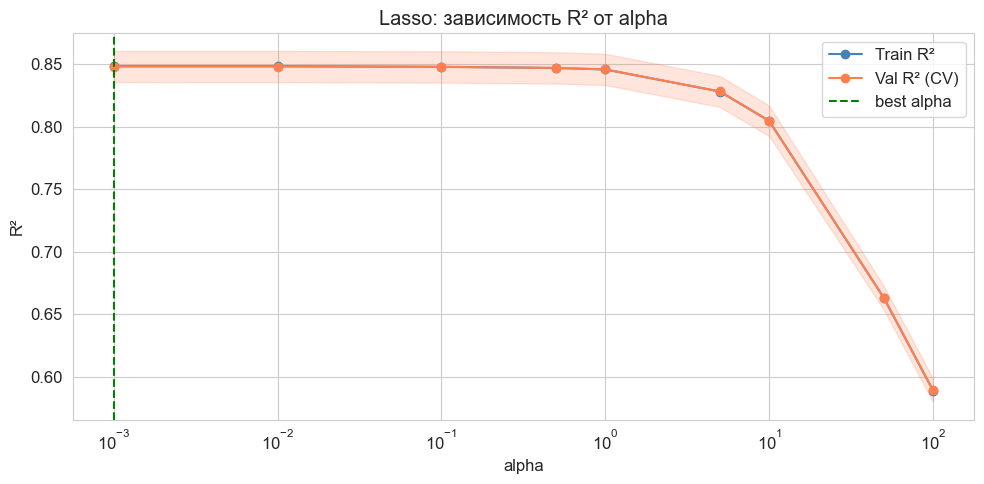

In [45]:
lasso_cv_results = pd.DataFrame(lasso_gs.cv_results_)

fig, ax = plt.subplots(figsize=(10, 5))
alphas = lasso_cv_results['param_model__alpha'].astype(float)
ax.plot(alphas, lasso_cv_results['mean_train_score'], 'o-', label='Train R²', color='steelblue')
ax.plot(alphas, lasso_cv_results['mean_test_score'], 'o-', label='Val R² (CV)', color='coral')
ax.fill_between(alphas,
                lasso_cv_results['mean_test_score'] - lasso_cv_results['std_test_score'],
                lasso_cv_results['mean_test_score'] + lasso_cv_results['std_test_score'],
                alpha=0.2, color='coral')
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('R²')
ax.set_title('Lasso: зависимость R² от alpha')
ax.legend()
ax.axvline(lasso_gs.best_params_['model__alpha'], color='green', linestyle='--', label='best alpha')
ax.legend()
plt.tight_layout()
plt.show()

### 13.2 Ridge: подбор alpha

In [46]:
print("Подбор alpha начат")
ridge_pipe = Pipeline([
    ('prep', preprocessor),
    ('model', Ridge(random_state=RANDOM_STATE))
])

ridge_params = {
    'model__alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]
}

ridge_gs = GridSearchCV(
    ridge_pipe, ridge_params, cv=kf, scoring='r2',
    return_train_score=True, n_jobs=-1
)
ridge_gs.fit(X_train, y_train)
print("Подбор alpha закончен")

print(f'Лучший alpha для Ridge: {ridge_gs.best_params_}')
print(f'Лучший R² (CV): {ridge_gs.best_score_:.4f}')
print(f'R² на тесте: {ridge_gs.score(X_test, y_test):.4f}')

Подбор alpha начат
Подбор alpha закончен
Лучший alpha для Ridge: {'model__alpha': 5.0}
Лучший R² (CV): 0.8483
R² на тесте: 0.8749


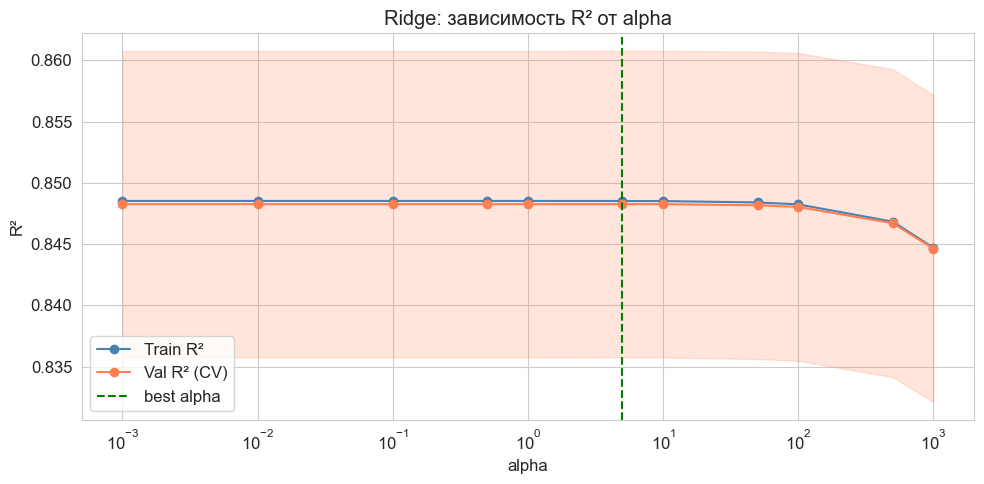

In [47]:
ridge_cv_results = pd.DataFrame(ridge_gs.cv_results_)

fig, ax = plt.subplots(figsize=(10, 5))
alphas = ridge_cv_results['param_model__alpha'].astype(float)
ax.plot(alphas, ridge_cv_results['mean_train_score'], 'o-', label='Train R²', color='steelblue')
ax.plot(alphas, ridge_cv_results['mean_test_score'], 'o-', label='Val R² (CV)', color='coral')
ax.fill_between(alphas,
                ridge_cv_results['mean_test_score'] - ridge_cv_results['std_test_score'],
                ridge_cv_results['mean_test_score'] + ridge_cv_results['std_test_score'],
                alpha=0.2, color='coral')
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('R²')
ax.set_title('Ridge: зависимость R² от alpha')
ax.axvline(ridge_gs.best_params_['model__alpha'], color='green', linestyle='--', label='best alpha')
ax.legend()
plt.tight_layout()
plt.show()

### 13.3 DecisionTree: подбор гиперпараметров

In [48]:
print("Подбор alpha начат")
tree_pipe = Pipeline([
    ('prep', preprocessor),
    ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

tree_params = {
    'model__max_depth': [5, 10, 15, 20, 30, None],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 2, 5, 10],
}

tree_gs = GridSearchCV(
    tree_pipe, tree_params, cv=kf, scoring='r2',
    return_train_score=True, n_jobs=-1
)
tree_gs.fit(X_train, y_train)
print("Подбор alpha закончен")

print(f'Лучшие параметры DecisionTree: {tree_gs.best_params_}')
print(f'Лучший R² (CV): {tree_gs.best_score_:.4f}')
print(f'R² на тесте: {tree_gs.score(X_test, y_test):.4f}')

Подбор alpha начат
Подбор alpha закончен
Лучшие параметры DecisionTree: {'model__max_depth': 15, 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}
Лучший R² (CV): 0.7840
R² на тесте: 0.8137


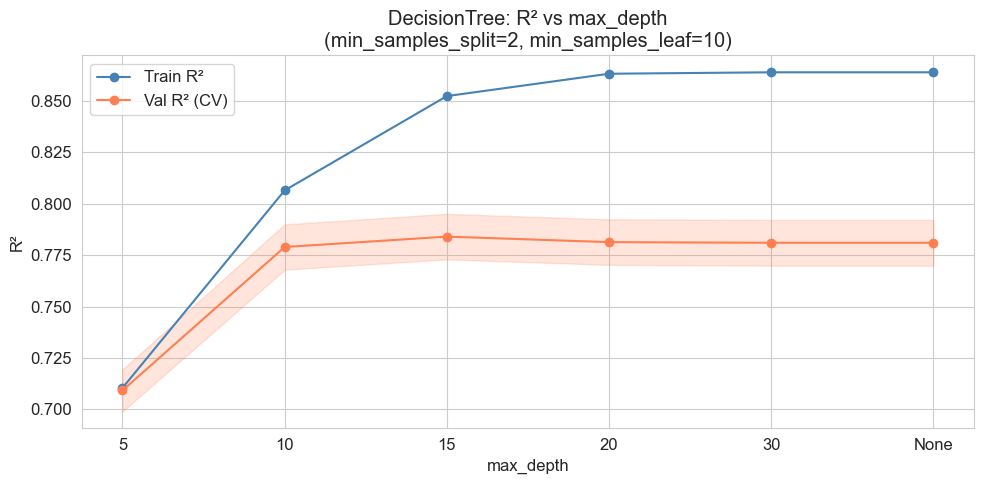

In [49]:
tree_cv_res = pd.DataFrame(tree_gs.cv_results_)

# R² от max_depth (при лучших остальных параметрах)
best_mss = tree_gs.best_params_['model__min_samples_split']
best_msl = tree_gs.best_params_['model__min_samples_leaf']

mask = (
    (tree_cv_res['param_model__min_samples_split'] == best_mss) &
    (tree_cv_res['param_model__min_samples_leaf'] == best_msl)
)
subset = tree_cv_res[mask].sort_values('param_model__max_depth')

fig, ax = plt.subplots(figsize=(10, 5))
depths = [str(d) for d in subset['param_model__max_depth']]
ax.plot(depths, subset['mean_train_score'], 'o-', label='Train R²', color='steelblue')
ax.plot(depths, subset['mean_test_score'], 'o-', label='Val R² (CV)', color='coral')
ax.fill_between(depths,
                subset['mean_test_score'] - subset['std_test_score'],
                subset['mean_test_score'] + subset['std_test_score'],
                alpha=0.2, color='coral')
ax.set_xlabel('max_depth')
ax.set_ylabel('R²')
ax.set_title(f'DecisionTree: R² vs max_depth\n(min_samples_split={best_mss}, min_samples_leaf={best_msl})')
ax.legend()
plt.tight_layout()
plt.show()

<a id='14'></a>
## 14. Сравнение моделей (финальное)

In [50]:
final_models = {
    'LinearRegression': models['LinearRegression'],
    f'Lasso (best alpha={lasso_gs.best_params_["model__alpha"]})': lasso_gs.best_estimator_,
    f'Ridge (best alpha={ridge_gs.best_params_["model__alpha"]})': ridge_gs.best_estimator_,
    f'DecisionTree (tuned)': tree_gs.best_estimator_,
}

final_results = {}
final_preds = {}

for name, pipe in final_models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    final_results[name] = {
        'R2': r2_score(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred),
    }
    final_preds[name] = y_pred

final_df = pd.DataFrame(final_results).T
display(final_df.style.highlight_min(
    subset=['RMSE', 'MAE', 'MAPE'], color='lightgreen'
).highlight_max(
    subset=['R2'], color='lightgreen'
))

,R2,RMSE,MAE,MAPE
LinearRegression,0.874860,203.280779,143.606471,0.076906
Lasso (best alpha=0.001),0.874863,203.278290,143.604426,0.076905
Ridge (best alpha=5.0),0.874874,203.269233,143.597145,0.076899
DecisionTree (tuned),0.813722,248.015396,180.043686,0.096230


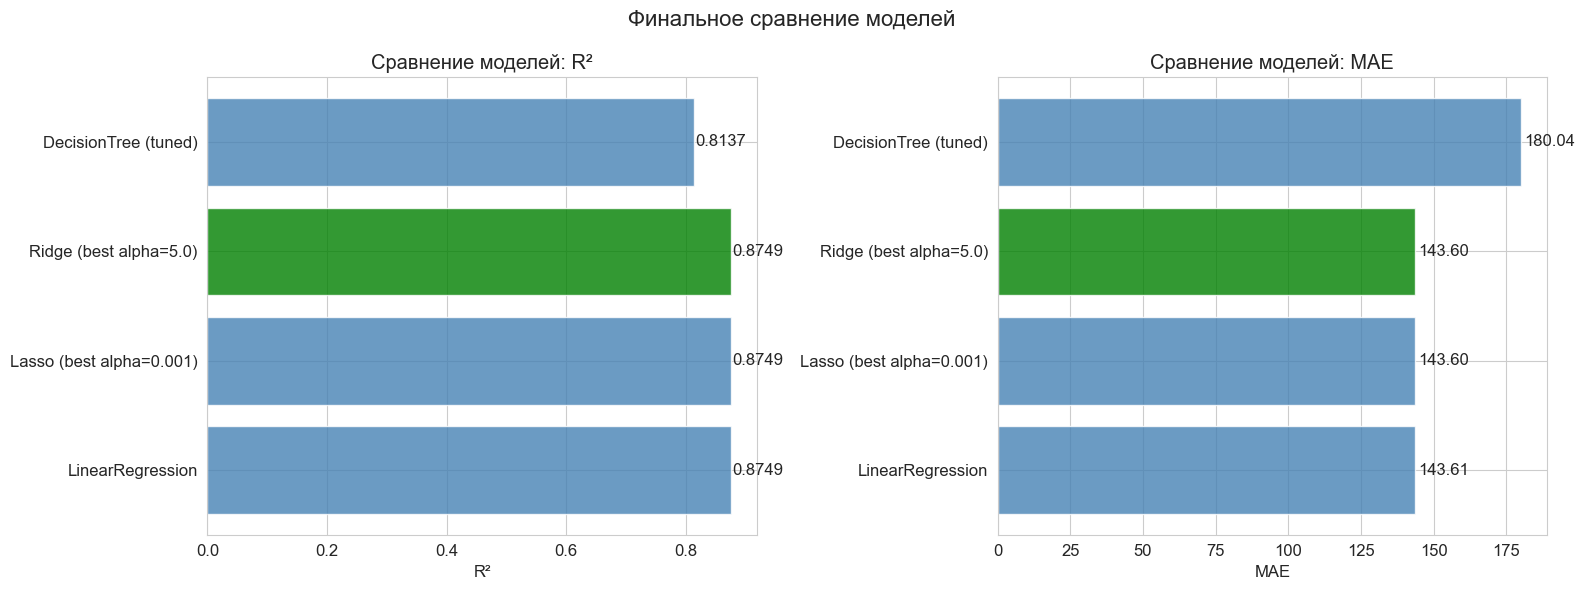

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# R² сравнение
names = final_df.index.tolist()
r2_vals = final_df['R2'].values
colors = ['steelblue'] * len(names)
best_idx = np.argmax(r2_vals)
colors[best_idx] = 'green'

axes[0].barh(names, r2_vals, color=colors, alpha=0.8)
axes[0].set_xlabel('R²')
axes[0].set_title('Сравнение моделей: R²')
for i, v in enumerate(r2_vals):
    axes[0].text(v + 0.002, i, f'{v:.4f}', va='center')

# RMSE сравнение
rmse_vals = final_df['MAE'].values
colors2 = ['steelblue'] * len(names)
best_idx2 = np.argmin(rmse_vals)
colors2[best_idx2] = 'green'

axes[1].barh(names, rmse_vals, color=colors2, alpha=0.8)
axes[1].set_xlabel('MAE')
axes[1].set_title('Сравнение моделей: MAE')
for i, v in enumerate(rmse_vals):
    axes[1].text(v + 1, i, f'{v:.2f}', va='center')

plt.suptitle('Финальное сравнение моделей', fontsize=16)
plt.tight_layout()
plt.show()

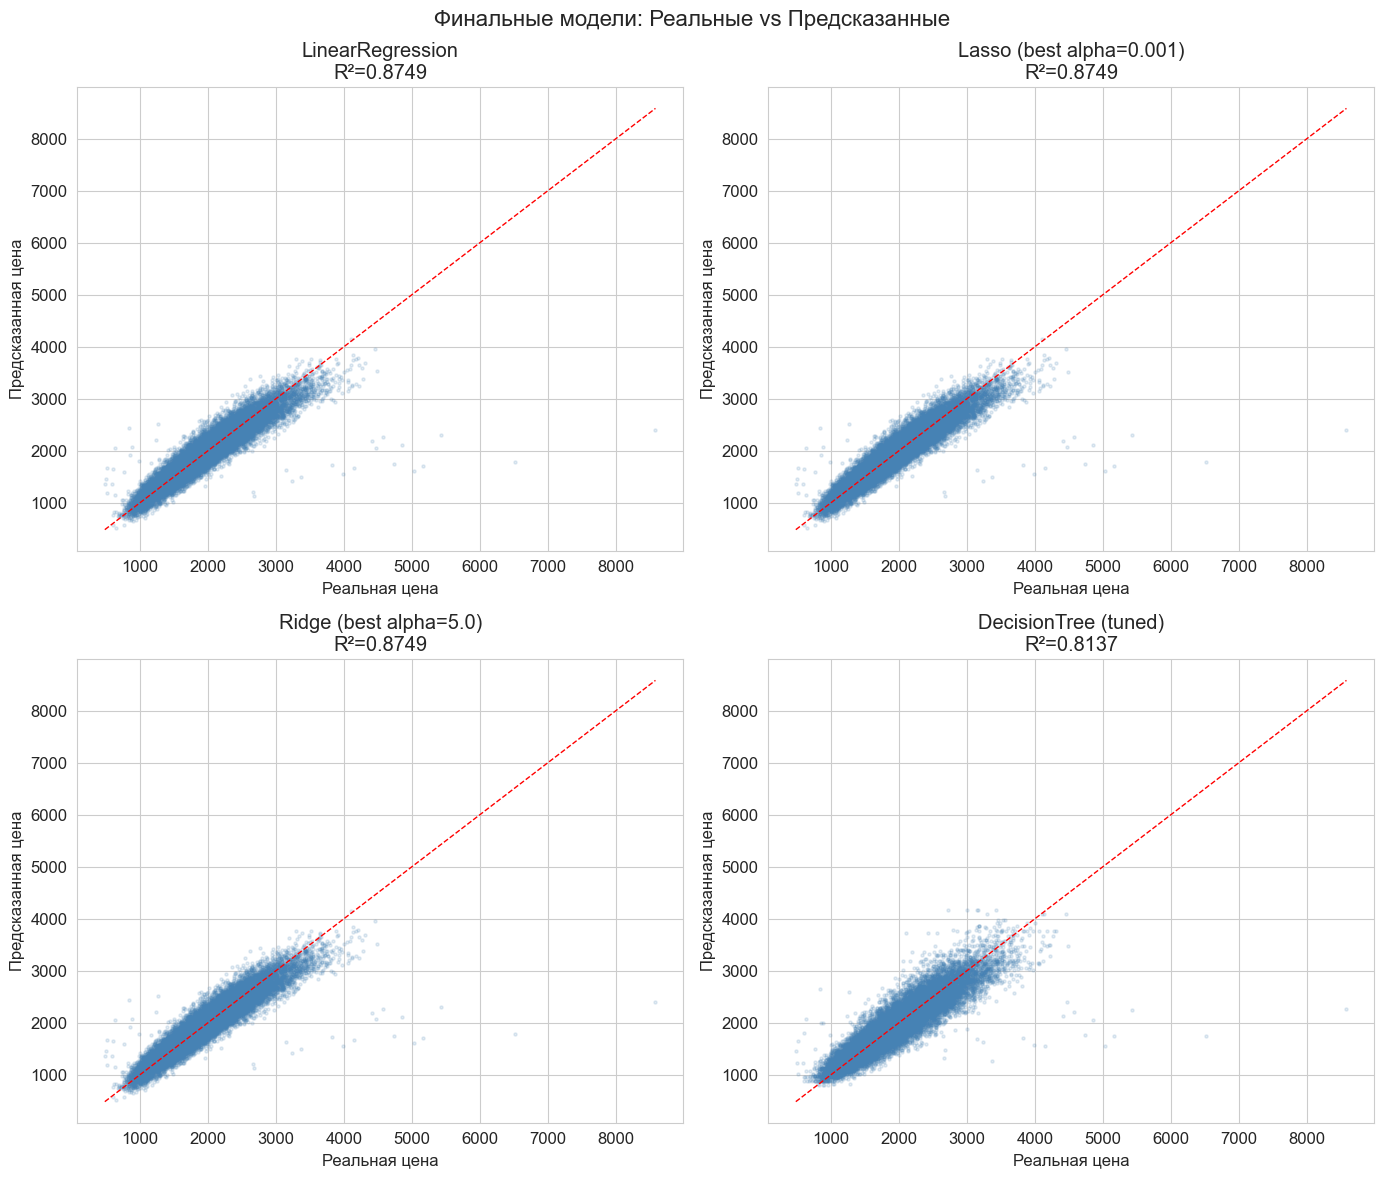

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, (name, y_pred) in enumerate(final_preds.items()):
    ax = axes[i]
    ax.scatter(y_test, y_pred, alpha=0.15, s=5, color='steelblue')
    lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
    ax.plot(lims, lims, 'r--', linewidth=1)
    ax.set_xlabel('Реальная цена')
    ax.set_ylabel('Предсказанная цена')
    ax.set_title(f'{name}\nR²={final_results[name]["R2"]:.4f}')

plt.suptitle('Финальные модели: Реальные vs Предсказанные', fontsize=16)
plt.tight_layout()
plt.show()

### Анализ важности признаков (для линейных моделей)

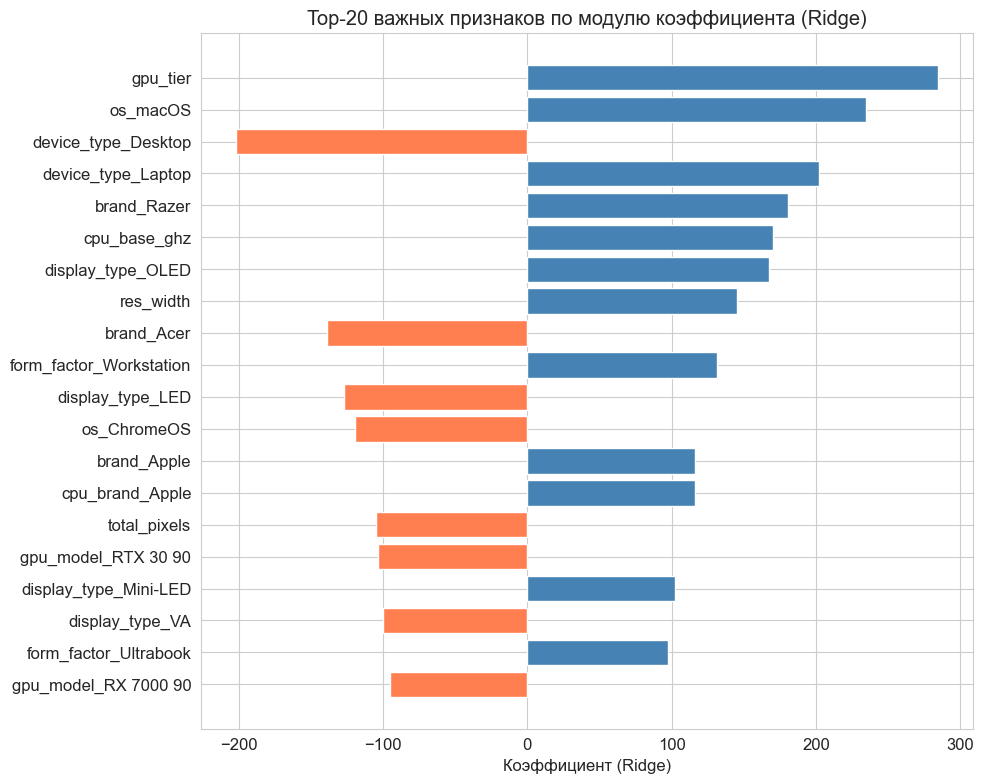

In [53]:
# Получаем имена признаков после OHE
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(cat_features).tolist()
all_feature_names = num_features_final + cat_feature_names

# Коэффициенты Ridge (best)
best_ridge = ridge_gs.best_estimator_
best_ridge.fit(X_train, y_train)
ridge_coefs = best_ridge.named_steps['model'].coef_

coef_df = pd.DataFrame({'feature': all_feature_names, 'coef': ridge_coefs})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False)

top_n = 20
fig, ax = plt.subplots(figsize=(10, 8))
top = coef_df.head(top_n)
colors = ['steelblue' if v > 0 else 'coral' for v in top['coef'].values]
ax.barh(top['feature'], top['coef'], color=colors)
ax.set_xlabel('Коэффициент (Ridge)')
ax.set_title(f'Top-{top_n} важных признаков по модулю коэффициента (Ridge)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

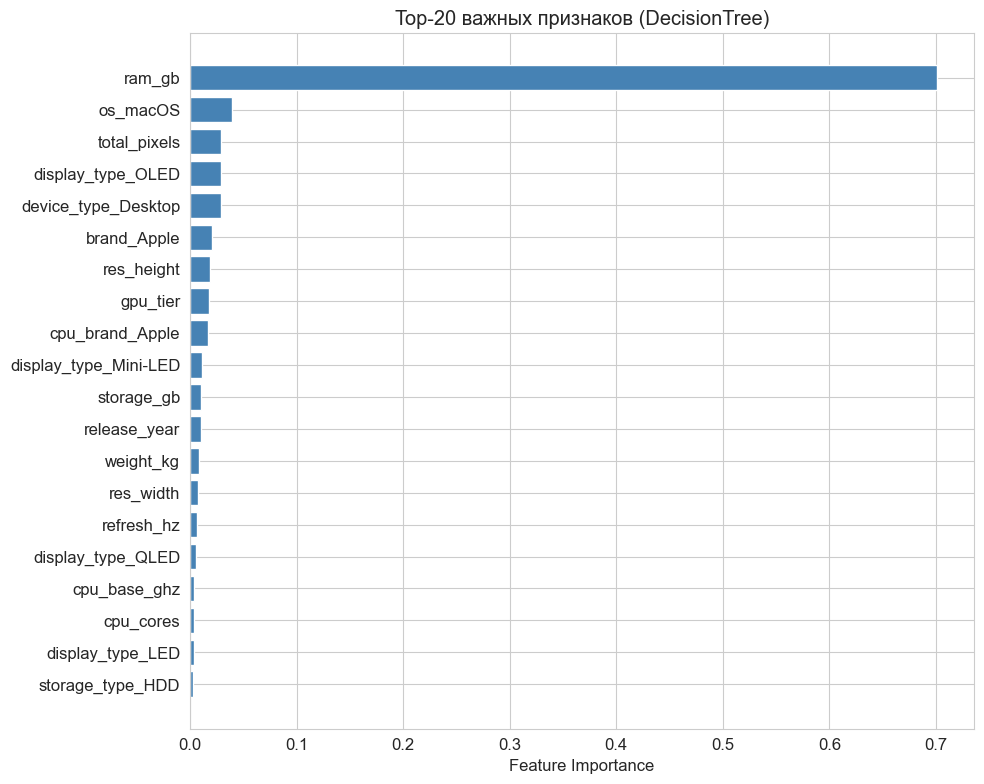

In [54]:
# Важность признаков (DecisionTree)
best_tree = tree_gs.best_estimator_
best_tree.fit(X_train, y_train)
tree_importances = best_tree.named_steps['model'].feature_importances_

imp_df = pd.DataFrame({'feature': all_feature_names, 'importance': tree_importances})
imp_df = imp_df.sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
top_imp = imp_df.head(top_n)
ax.barh(top_imp['feature'], top_imp['importance'], color='steelblue')
ax.set_xlabel('Feature Importance')
ax.set_title(f'Top-{top_n} важных признаков (DecisionTree)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()